
<h2><center> Quantitative Trading Strategies - Assignment 6 </center></h2>


<h3><span style="color:#00008B">Submitted by - Krishna Vardhan Diggavi </span></h3>

<h3><span style="color:#00008B">Email - krishnadiggavi@uchicago.edu</span></h3>

# Import functions

In [1282]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import os
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import zscore
pd.options.mode.chained_assignment = None 
import seaborn as sns
import pandas_market_calendars as mcal
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
plt.style.use('seaborn')
quandl.ApiConfig.api_key = 'nVwoRNxyU88t5sMKgzAt'

###  In this assignment we are going to do Predictive Regression mainly using Boxcar OLS regression and Exponentially Decaying regression for predicting hedged CDS spread returns. <br>

# Boxcar OLS Regression

### Description:<br>
- Boxcar OLS regression is a type of ordinary least squares regression applied to time series data. In Boxcar OLS regression, a moving average window of fixed width is applied to the data, and the linear regression model is fitted to the data within each window. This approach can be useful for analyzing data that has a significant amount of noise and for detecting trends over time. However, it can be sensitive to the choice of window size and may not perform well when the underlying relationship between the variables is nonlinear. <br>

### Advantages:<br>
- Easy to implement and understand, especially for users who are familiar with linear regression analysis. <br><br>
- Can provide a useful estimate of a trend over time, even in the presence of noise in the data.<br><br>
- Allows for easy comparison of regression coefficients across different time intervals, which can be useful for detecting changes in the relationship between the variables over time.<br><br>
- Can be applied to non-time series data as well, making it a versatile regression technique. <br>

### Disadvantages:<br>
- The choice of the window size can have a significant impact on the results, and different window sizes may be appropriate for different data sets. <br><br>
- Assumes that the relationship between the variables is linear, which may not be appropriate for all time series data.<br><br>
- May be less effective in detecting short-term changes in the relationship between the variables, as it is based on a moving average that smooths out the data.<br>

### How to tackle disadvantages:<br>
- To address the sensitivity to window size, try using a range of window sizes and compare the results to see which size works best for the data at hand. <br><br>
- To address the assumption of a linear relationship, consider using other regression techniques, such as polynomial regression or regression trees, that can capture nonlinear relationships.<br><br>
- To address the smoothing effect of the moving average, try using alternative moving average methods, such as weighted moving averages or rolling medians, that may be less susceptible to outliers.<br>

# Exponentially Decaying Regression 

### Description:<br>
- Exponentially Decaying regression, on the other hand, applies a weighted least squares regression to time series data. In this approach, the weights of the observations are determined by an exponential decay function, with more recent observations receiving higher weights. This allows the regression model to give greater emphasis to recent data, which can be useful for forecasting short-term trends. This approach can be especially effective when there is a known time decay factor affecting the data. <br>

### Advantages:<br>
- Takes into account the recency of the data, which can be especially useful for forecasting short-term trends or detecting changes in the relationship between the variables. <br><br>
- Provides a more flexible way to model the variance of the errors than Boxcar OLS regression, since the weights of the observations can be adjusted to reflect the degree of uncertainty in the data.<br><br>
- Can be used to model relationships that exhibit a natural time decay, such as the decay of a drug in a patient's bloodstream over time.<br>


### Disadvantages:<br>
- More difficult to understand and implement than Boxcar OLS regression, particularly for users who are not familiar with weighted regression analysis. <br><br>
- Assumes that the relationship between the variables can be modeled as an exponential decay function, which may not be appropriate for all time series data.<br><br>
- The choice of the decay rate can have a significant impact on the results, and different decay rates may be appropriate for different data sets.<br>

### How to tackle disadvantages:<br>
- To address the difficulty of implementation, try using software or libraries that have built-in functions for Exponentially Decaying regression, such as the statsmodels library in Python. <br><br>
- To address the assumption of an exponential decay relationship, consider using other models that can capture different types of time series relationships, such as autoregressive models or state space models.<br><br>
- To address the sensitivity to the decay rate, try using a range of decay rates and compare the results to see which rate works best for the data at hand.<br>

# General comments on when it is suitable to use each of the Regression ?

### Use Boxcar OLS regression when:<br>
- The time series data exhibits a relatively stable trend over time. <br><br>
- The goal is to estimate a trend over a longer time period.<br><br>
- The relationship between the variables is expected to be linear.<br>

### Use Exponentially Decaying regression when:<br>
- The time series data exhibits a short-term trend that is expected to decay over time. <br><br>
- The goal is to forecast short-term trends or detect changes in the relationship between the variables.<br><br>
- The variance of the errors in the data is expected to vary over time.<br>
- The relationship between the variables is expected to decay over time.<br>

# 1 Data

### Spread data

In [1283]:
data = pd.read_csv(r'C:\Users\Krishna Diggavi\Downloads\Liq5YCDS.delim', sep="\t")
data['date'] = pd.to_datetime(data['date'])
data.head()


,Unnamed: 0,date,ticker,tenor,parspread,upfront,runningcoupon,cdsrealrecovery,cdsassumedrecovery,docclause,currency,tier,impliedrating
0,0,2018-01-01,BA,5Y,0.001793,-0.038914,0.01,0.40,0.4,MR14,USD,SNRFOR,BBB
1,1,2018-01-01,C,5Y,0.004113,-0.027708,0.01,0.40,0.4,MR14,USD,SNRFOR,A
2,2,2018-01-01,DD,5Y,0.002476,-0.035641,0.01,0.40,0.4,MR14,USD,SNRFOR,A
3,3,2018-01-01,F,5Y,0.008805,-0.192592,0.05,0.39,0.4,MR14,USD,SNRFOR,BB
4,4,2018-01-01,GE,5Y,0.004037,-0.028103,0.01,0.40,0.4,MR14,USD,SNRFOR,BBB


In [1284]:
tickers = set(data['ticker'])

### Adj Close prices for above tickers

In [1285]:
adjclose = quandl.get_table('QUOTEMEDIA/PRICES', ticker=list(tickers), date={'gte':'2018-01-01','lte': '2022-12-31'}, paginate=True)
adjclose = adjclose[['ticker', 'date', 'adj_close']]
adjclose['date'] = pd.to_datetime(adjclose['date'])


### Resampling and calculating Returns for Equity prices and Spread

In [1286]:
adj_close_spread = adjclose[['ticker','date','adj_close']].set_index('date').groupby('ticker').resample('W-Wed').last().drop(columns={'ticker'})
adj_close_spread['rEquity'] = adj_close_spread.groupby('ticker')['adj_close'].pct_change()
adj_close_spread = adj_close_spread.reset_index()


In [1287]:
spread_data = data[['ticker','date','parspread']].set_index('date').groupby('ticker').resample('W-Wed').last().drop(columns={'ticker'})
spread_data['rCDS'] = (spread_data['parspread'] - spread_data.groupby('ticker')['parspread'].shift(1)) / spread_data.groupby('ticker')['parspread'].shift(1)
spread_data = spread_data.reset_index()


In [1288]:
df_returns = adj_close_spread[['ticker', 'date', 'rEquity']].merge(spread_data[['ticker', 'date', 'rCDS']], on=['ticker', 'date'])


### SPY ETF data

In [1289]:
SPY = quandl.get_table('QUOTEMEDIA/PRICES', ticker='SPY', date={'gte':'2018-01-01','lte': '2022-12-31'}, paginate=True)
df_spy = SPY[SPY['ticker'] == 'SPY'][['date', 'adj_close']]
df_spy_w = df_spy.set_index('date').resample('W-WED').last().reset_index()
df_spy_w['m'] = df_spy_w['adj_close'].pct_change()
df_spy_w.fillna(0, inplace=True)

In [1290]:
df_all_returns = df_returns.merge(df_spy_w[['date', 'm']], on='date')
df_all_returns.fillna(0, inplace=True)
df_all_returns = df_all_returns.set_index('date')

### Equity prices and SPY returns merged

In [1291]:
df_pivot = pd.pivot_table(df_all_returns, values='rEquity', index='date', columns='ticker')
df_spy_w = df_spy_w.set_index('date')
result = df_pivot.join(df_spy_w[['m']])
result.fillna(0, inplace=True)
result.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX,m
date,,,,,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-10,0.075420,0.014211,0.015743,0.021160,0.042920,0.025506,0.071882,0.023364,-0.030042,0.009161,0.0,-0.014385,0.025341,-0.007151,0.034777,0.013495
2018-01-17,0.096016,0.024058,0.021159,-0.065234,-0.083417,0.024853,0.002295,0.079749,0.049396,0.031227,0.0,0.006281,0.012041,0.022305,0.051730,0.020028
2018-01-24,-0.046494,0.025558,0.003167,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.0,0.004613,0.025047,0.006023,0.013784,0.012768
2018-01-31,0.058801,-0.012209,-0.005657,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,0.0,0.011615,0.004582,-0.013894,0.054697,-0.004520


# 2 Models

### Contemporaneous model of the (CAPM) form $$r^{Equity}_{E} = m + \epsilon $$

In [1292]:
import statsmodels.regression.linear_model as linreg

def boxcar_5_reg_k(_df):
    coeffs = []
    for col in _df.columns:
        p = linreg.OLS(_df[col], _df['m']).fit(params_only=True).params
        coeffs.append(p)
    return [float(c) for c in coeffs]


In [1293]:
b_5_coeffs_dict = {result.index[i-1]: boxcar_5_reg_k(result.iloc[i-16:i]) for i in range(16, result.shape[0])}
b_5_coeffs_SPY = pd.DataFrame.from_dict(b_5_coeffs_dict, orient='index', columns=result.columns)
b_5_coeffs_SPY.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX,m
2018-04-18,0.923038,0.929740,1.438855,0.260754,0.440073,0.814211,1.122543,0.827891,0.854317,1.175389,0.0,0.262116,1.547939,1.364750,1.553333,1.0
2018-04-25,0.816514,0.822387,1.547017,0.258805,0.292399,0.715327,0.961894,0.946218,0.907676,1.094558,0.0,0.238710,1.201914,1.224163,1.362702,1.0
2018-05-02,0.696447,0.820549,1.557608,0.219861,0.209255,0.686917,0.854078,0.916273,1.002414,1.111346,0.0,0.297400,1.186870,1.281183,1.338504,1.0
2018-05-09,0.615251,0.953703,1.597405,0.361658,0.564701,0.776904,0.818395,0.673546,0.784200,1.089054,0.0,0.197281,1.255875,1.327330,1.082229,1.0
2018-05-16,0.702168,0.913058,1.652134,0.432619,0.713816,0.737264,0.826026,0.596201,0.946916,1.094686,0.0,0.234131,1.255451,1.383655,1.050522,1.0


### Equity, Spread and SPY returns combined 

In [1294]:
df_pivot_CDS_spread = pd.pivot_table(df_all_returns, values='rCDS', index='date', columns='ticker')
col_means = df_pivot_CDS_spread.mean()
for col in df_pivot_CDS_spread.columns:
    df_pivot_CDS_spread[f'{col}_mean'] = col_means[col]

In [1295]:
result1 = result.add_suffix('_equity')
result_combined = pd.merge(df_pivot_CDS_spread, result1, on='date')
result_combined.fillna(0, inplace=True)
result_combined.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,...,LNC_equity,LOW_equity,LUV_equity,MAR_equity,NFLX_equity,T_equity,WFC_equity,XOM_equity,XRX_equity,m_equity
date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-10,-0.057555,-0.002449,0.012286,0.017203,0.009527,0.028725,-0.021380,-0.073064,0.045735,0.036897,...,0.071882,0.023364,-0.030042,0.009161,0.0,-0.014385,0.025341,-0.007151,0.034777,0.013495
2018-01-17,0.090416,-0.004649,0.046848,0.093586,0.154969,-0.020475,0.010851,0.449611,0.069635,0.137440,...,0.002295,0.079749,0.049396,0.031227,0.0,0.006281,0.012041,0.022305,0.051730,0.020028
2018-01-24,0.004652,0.006147,0.059232,0.074893,0.256980,-0.000440,0.001468,0.206392,0.073706,0.010891,...,0.004338,0.053585,-0.058423,0.016831,0.0,0.004613,0.025047,0.006023,0.013784,0.012768
2018-01-31,-0.016092,-0.018857,0.037755,0.026133,-0.007615,-0.020960,-0.002848,0.061483,0.030513,-0.071606,...,-0.006479,-0.018647,-0.022665,0.020431,0.0,0.011615,0.004582,-0.013894,0.054697,-0.004520


### Contemporaneous model of the form $$r^{CDSE} ∼r^{Equity}_{E} + r^{Index} + \epsilon $$

In [1296]:
def boxcar_5_reg_n(_df):
    coeffs = {}
    cols = [col for col in _df.columns if not col.endswith(('_equity', '_mean'))]
    for col in cols:
        exog = _df[[f"{col}_equity", f"{col}_mean"]]
        p = linreg.OLS(_df[col], exog).fit(params_only=True).params
        coeffs[col] = p
    return pd.concat(coeffs)

In [1297]:
b_5_coeffs = pd.concat([boxcar_5_reg_n(result_combined.iloc[i-16:i]) for i in range(16, result_combined.shape[0])], axis=1).T
b_5_coeffs.index = result_combined.index[15:-1] 
b_5_coeffs.head()

BA                   C                  DD            \
           BA_equity   BA_mean  C_equity    C_mean DD_equity   DD_mean   
date                                                                     
2018-04-18 -0.458219  2.322565 -0.486300  1.937387 -1.588537  6.649475   
2018-04-25 -0.474073  2.510447 -0.451220  2.329076 -1.200084  6.556108   
2018-05-02 -0.229296  2.590274 -0.405653  2.376931 -1.187850  6.322470   
2018-05-09 -0.628359  2.195011 -0.699632  1.798391 -1.243430  6.048980   
2018-05-16 -0.755803  2.233689 -0.706515  2.100451 -1.274371  5.826847   

                   F                  GE            ...        NFLX            \
            F_equity    F_mean GE_equity   GE_mean  ... NFLX_equity NFLX_mean   
date                                                ...                         
2018-04-18 -0.787558  1.653054 -1.325743  3.215208  ...         0.0       0.0   
2018-04-25 -0.780362  1.902632 -1.470846  2.771932  ...         0.0       0.0   
2018-05-02 -0.797335  1.874524 -1.661674  2.067392  ...         0.0       0.0   
2018-05-09 -0.661266  1.863706 -1.600651  2.347221  ...         0.0       0.0   
2018-05-16 -0.594441  1.612401 -1.101912  1.693381  ...         0.0       0.0   

                   T                  WFC                  XOM            \
            T_equity    T_mean WFC_equity  WFC_mean XOM_equity  XOM_mean   
date                                                                       
2018-04-18  0.611288 -0.813527  -0.854112  1.294345  -0.115333  0.872821   
2018-04-25  0.607165 -0.875739  -0.639121  2.524755  -0.115871  0.855428   
2018-05-02  0.069342 -1.088540  -0.636062  2.306179  -0.095364  0.864359   
2018-05-09  0.053060 -1.080582  -0.784613  1.284266  -0.095216  1.102330   
2018-05-16  0.058510 -1.072414  -0.752707  1.584967  -0.026930  3.198603   

                  XRX            
           XRX_equity  XRX_mean  
date                             
2018-04-18  -2.493150 -1.468487  
2018-04-25  -2.479350 -1.251931  
2018-05-02  -3.099118  2.106732  
2018-05-09  -2.860931  1.467336  
2018-05-16  -3.037515  3.520994  

[5 rows x 30 columns]

In [1298]:
k = result_combined.index >= '2018-04-18'
result_combined_filtered = result_combined[k]

### Hedge portfolio return 

### $$f_{E,n} = \beta_{E,Equity}^{(n)}r_{E,n}^{Equity} +\beta_{E,Index}^{(n)}r_{n}^{Index}  $$

In [1299]:
def hedge_ratio_return(_df, df1):
    results = {}
    cols = [col for col in _df.columns if not col.endswith(('_equity', '_mean'))]

    for col in cols:
        hedge_ratio_return = _df[f"{col}_mean"] * df1[col][f"{col}_mean"] + _df[f"{col}_equity"] * df1[col][f"{col}_equity"]
        results[col] = hedge_ratio_return

    return pd.DataFrame(results)


In [1300]:
hedge_ratio_return = hedge_ratio_return(result_combined_filtered, b_5_coeffs)
hedge_ratio_return = hedge_ratio_return.dropna()
hedge_ratio_return.head()


,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-04-18,0.023287,0.020620,-0.026078,0.023992,-0.034871,0.026731,-0.016973,0.067298,0.022694,-0.019692,0.0,-0.003673,0.033804,-0.000878,-0.189811
2018-04-25,0.043222,0.014691,0.132799,0.024364,-0.011251,0.016455,0.003316,0.010303,0.061826,0.048882,0.0,-0.003380,-0.017967,0.001343,-0.040144
2018-05-02,0.059751,0.025542,0.055707,0.012216,0.007554,0.033449,0.037010,0.134432,0.055863,0.059279,0.0,-0.010172,0.026119,0.005009,0.144000
2018-05-09,0.000687,-0.030974,0.000873,0.028130,-0.023636,-0.043999,0.012278,0.049261,0.042382,-0.012495,0.0,-0.005050,-0.021310,-0.001623,0.065088
2018-05-16,0.044785,0.015490,0.010160,-0.001593,-0.012121,0.016510,0.009116,0.004839,0.013704,-0.003976,0.0,-0.002250,-0.007544,0.005569,0.057170


### Residual Return

### $$\\rho_{E,n} = r^{CDS}_{E,n} - f_{E,n}$$

In [1301]:
def residual(_df, df1):
    results = {}
    cols = [col for col in _df.columns if not col.endswith(('_equity', '_mean'))]

    for col in cols:
        
        residual = _df[col] - df1[col]
        results[col] = residual

    return pd.DataFrame(results)

In [1302]:
residual = residual(result_combined_filtered, hedge_ratio_return).fillna(0)
residual.fillna(0, inplace=True)
residual = residual[4:]
residual.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-05-16,-0.059727,0.044757,-0.011455,0.006708,-0.012863,0.024234,-0.005235,-0.021667,-0.013213,-0.039122,0.0,0.002203,0.023598,0.026077,0.404237
2018-05-23,0.006069,-0.022822,-0.054141,-0.057284,-0.067349,-0.030759,0.020831,0.042321,-0.048439,-0.008717,0.0,0.005195,0.004164,0.001000,-0.032812
2018-05-30,0.020265,0.051174,-0.030702,0.030569,0.024876,0.057102,0.018082,-0.004752,-0.002878,0.053861,0.0,0.003969,0.064387,0.003578,-0.078162
2018-06-06,-0.026308,-0.008249,0.042755,-0.021232,-0.023933,-0.041945,-0.020271,-0.060197,-0.034108,0.020606,0.0,0.002277,-0.027690,0.001651,-0.115057
2018-06-13,-0.002341,-0.047495,-0.056071,-0.024121,-0.000474,-0.043677,-0.028971,-0.035289,-0.046460,-0.085631,0.0,0.005635,-0.028664,-0.002146,-0.095485


### Residual Equity Return

### $$ c_{E,n} = r^{Equity}_{E,n} - \gamma_{E,n}m_{n}$$

In [1303]:
def residual_equity(_df, df1):
    results = {}
    cols = [col for col in _df.columns if not col.endswith(('_equity', '_mean'))]
    for col in cols:
        residual_equity = _df[f"{col}_equity"] - df1[col]*_df["m_equity"]
        results[col] = residual_equity

    return pd.DataFrame(results)

In [1304]:
residual_equity = residual_equity(result_combined_filtered,b_5_coeffs_SPY ).fillna(0)
residual_equity_shift = residual_equity.shift(1).fillna(0)
residual_equity_shift = residual_equity_shift[3:] 


In [1305]:
residual_equity_shift = residual_equity_shift[1:]
residual_equity_shift.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-05-16,0.047922,0.040400,0.001771,-0.022038,0.017513,0.032275,-0.021509,-0.010643,-0.031220,0.001809,0.0,-0.025309,0.007816,0.008984,-0.044625
2018-05-23,-0.012467,-0.009283,0.013492,0.026343,0.020786,-0.008113,-0.002776,0.006850,0.018495,0.007290,0.0,0.026282,0.011045,0.022433,-0.020393
2018-05-30,0.050302,-0.027430,-0.021300,0.001906,-0.059301,-0.010515,0.022739,0.104680,-0.054450,-0.021908,0.0,-0.000070,0.015479,-0.004075,-0.022645
2018-06-06,0.000020,-0.048001,-0.022778,0.010682,0.000339,-0.034294,-0.035949,0.030115,0.022419,-0.006460,0.0,0.008019,-0.033056,-0.005799,-0.007040
2018-06-13,0.017319,0.006095,0.044747,0.027298,-0.041702,0.002671,0.005789,0.001596,-0.021831,0.018412,0.0,0.019103,0.014171,-0.006241,-0.015958


# Regressing Residual return with lagged version of Residual Equity Return

### $$\\rho_{E,n}  ∼ c_{E,n-1} + \epsilon $$

### Boxcar Regression function

In [1306]:
import statsmodels.regression.linear_model as linreg

def boxcar_5_reg_residual(_df, df1):
    coeffs = []
    for col in _df.columns:
        p = linreg.OLS(_df[col], df1[col]).fit(params_only=True).params
        coeffs.append(p)
    return [float(c) for c in coeffs]


### Exponential Deccaying Resgression function

In [1308]:
import statsmodels.regression.linear_model as linreg

def exp_1_2_reg(_df, df1, half_life, threshold):
    
    half_life = half_life
    lma = 2**(-1./half_life)
    threshold = 1. / (residual_equity_shift.shape[0]* threshold)
    w12 = lma**np.arange(residual_equity_shift.shape[0]-1, -1, -1)
    # Cuts off weight values too small to care about, allowing use of naive routines without losing accuracy or having too many points
    exp_1p2_wts = w12[ w12 > threshold]
    enough_points = np.where( w12 > 1./20 )[0].shape[0]

    coeffs = []
    _n = min(exp_1p2_wts.shape[0], _df.shape[0])
    _ldf = _df.iloc[-_n:]
    _wt = exp_1p2_wts[-_n:]
    for col in _df.columns:
        _p = linreg.WLS(_ldf[col], df1[col], weights=_wt).fit(params_only=True).params
        coeffs.append(_p)
    return [float(c) for c in coeffs]


### Implementing Regression functions with different half life and window sizes

In [1384]:
def regression_implementation(regression, _df, df1, half_life, window_size):
    if regression == boxcar_5_reg_residual:
        b_5_coeffs_dict = {_df.index[i-1]: regression(_df.iloc[i-half_life:i], df1.iloc[i-half_life:i]) for i in range(half_life, _df.shape[0])}
        betas_box_car = pd.DataFrame.from_dict(b_5_coeffs_dict, orient='index', columns=_df.columns)
        return betas_box_car
    elif regression == exp_1_2_reg:
        b_5_coeffs_dict = {_df.index[i-1]: regression(_df.iloc[max(0,i-exp_1p2_wts.shape[0]):i], df1.iloc[max(0,i-exp_1p2_wts.shape[0]):i], window_size, 500) for i in range(enough_points, _df.shape[0])}
        betas_exponential = pd.DataFrame.from_dict(b_5_coeffs_dict, orient='index', columns=_df.columns)
        return betas_exponential
    elif regression == lasso_regression:
        b_5_coeffs_dict = {_df.index[i-1]: regression(_df.iloc[i-half_life:i], df1.iloc[i-half_life:i]) for i in range(half_life, _df.shape[0])}
        betas_lasso = pd.DataFrame.from_dict(b_5_coeffs_dict, orient='index', columns=_df.columns)
        return betas_lasso
    elif regression == ridge_regression:
        b_5_coeffs_dict = {_df.index[i-1]: regression(_df.iloc[i-half_life:i], df1.iloc[i-half_life:i]) for i in range(half_life, _df.shape[0])}
        betas_ridge = pd.DataFrame.from_dict(b_5_coeffs_dict, orient='index', columns=_df.columns)
        return betas_ridge
    elif regression == pca_regression:
        b_5_coeffs_dict = {_df.index[i-1]: regression(_df.iloc[i-half_life:i], df1.iloc[i-half_life:i]) for i in range(half_life, _df.shape[0])}
        betas_pca = pd.DataFrame.from_dict(b_5_coeffs_dict, orient='index', columns=_df.columns)
        return betas_pca


# Calculating Residuals of both the Predcitive model

### $$q_{E,n} = \rho_{E,n}-\mu_{E,n-1}c_{E,n-1}$$

### Residual function for both models

In [ ]:
def residual_errors(_df, df1, df2):
    results = {}
    df1 = df1.shift(1).fillna(0) 
    for col in _df.columns:
        residual_errors = _df[col] - df1[col]*df2[col]
        results[col] = residual_errors
    return pd.DataFrame(results)

# half life =12 and window size = 16

In [1311]:
betas_box_car_16 = regression_implementation(boxcar_5_reg_residual, residual, residual_equity_shift, 12, 16 )
betas_exponential_12 = regression_implementation(exp_1_2_reg, residual, residual_equity_shift, 12, 16)

### Exponential Decaying regression residuals 

In [1313]:
residual_errors_exponential_12 = residual_errors(residual,betas_exponential_12,residual_equity_shift)
residual_errors_exponential_12= residual_errors_exponential_12.dropna()
residual_errors_exponential_12.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.098969,0.060207,0.071524,0.090147,0.034273,0.041435,-0.015676,0.067196,0.037814,0.058010,0.0,-0.002266,0.070831,-0.000503,-0.018765
2019-05-15,-0.055336,-0.017881,-0.000965,0.007544,0.016221,-0.000901,0.012875,0.059244,0.024536,0.033229,0.0,-0.005997,0.005567,0.023610,-0.018912
2019-05-22,0.033962,0.002448,0.014009,-0.008871,-0.060294,0.010222,0.036489,0.046876,-0.019561,-0.060727,0.0,-0.011513,-0.004292,-0.009481,-0.012568
2019-05-29,-0.020968,0.120094,0.053782,0.041238,0.021343,0.100654,0.014697,-0.014663,0.005539,0.012042,0.0,-0.004669,0.101065,0.003174,0.022061
2019-06-05,-0.064846,-0.045946,0.039015,-0.010358,0.080124,-0.098996,-0.024161,-0.048259,-0.055858,-0.034371,0.0,-0.011740,-0.062825,-0.008116,0.011252


### Boxcar Regression residuals

In [1314]:
residual_errors_box_car_16 = residual_errors(residual,betas_box_car_16,residual_equity_shift)
residual_errors_box_car_16 = residual_errors_box_car_16.dropna()
k = residual_errors_box_car_16.index >= '2019-05-08'
residual_errors_box_car_16 = residual_errors_box_car_16[k]
residual_errors_box_car_16.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.099642,0.061723,0.057903,0.165761,0.020831,0.038166,-0.007203,0.051843,0.050364,0.077653,0.0,-0.002426,0.065384,-0.005591,-0.026227
2019-05-15,-0.053672,-0.017927,0.036829,0.000738,0.022290,-0.000637,0.019319,0.055327,0.022413,0.033238,0.0,-0.004948,0.026878,0.021941,-0.011602
2019-05-22,0.035465,0.008033,0.019143,-0.012868,-0.055813,0.012140,0.031296,0.053926,-0.019016,-0.060679,0.0,-0.013789,0.007072,-0.004295,0.003499
2019-05-29,-0.022109,0.121390,0.046392,0.064404,0.013726,0.099394,0.018128,-0.029628,0.012058,0.018422,0.0,-0.002301,0.096242,-0.001688,0.016331
2019-06-05,-0.064701,-0.049733,0.030052,-0.012455,0.076868,-0.102880,-0.017648,-0.048382,-0.077208,-0.037337,0.0,-0.011443,-0.062969,-0.012203,0.030255


# half life =16 and window size = 20

In [1315]:
betas_box_car_20 = regression_implementation(boxcar_5_reg_residual, residual, residual_equity_shift, 16, 20 )
betas_exponential_16 = regression_implementation(exp_1_2_reg, residual, residual_equity_shift, 16, 20)

### Exponential Decaying regression residuals 

In [1316]:
residual_errors_exponential_16 = residual_errors(residual,betas_exponential_16,residual_equity_shift)
residual_errors_exponential_16= residual_errors_exponential_16.dropna()
residual_errors_exponential_16.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.098969,0.060207,0.071524,0.090147,0.034273,0.041435,-0.015676,0.067196,0.037814,0.058010,0.0,-0.002266,0.070831,-0.000503,-0.018765
2019-05-15,-0.055526,-0.017881,-0.001680,0.008241,0.015981,-0.000938,0.012445,0.059710,0.024726,0.033222,0.0,-0.006087,0.005002,0.023662,-0.019252
2019-05-22,0.033664,0.002462,0.013882,-0.008472,-0.060445,0.010056,0.036826,0.045969,-0.019610,-0.060801,0.0,-0.011233,-0.004601,-0.009672,-0.013300
2019-05-29,-0.020787,0.120101,0.053913,0.040142,0.021624,0.100724,0.014450,-0.011834,0.005320,0.011242,0.0,-0.004562,0.101189,0.003381,0.022318
2019-06-05,-0.064866,-0.046165,0.039432,-0.010274,0.080215,-0.098672,-0.024628,-0.048151,-0.055139,-0.034000,0.0,-0.011735,-0.062821,-0.007890,0.010373


### Boxcar Regression residuals

In [1317]:
residual_errors_box_car_20 = residual_errors(residual,betas_box_car_20,residual_equity_shift)
residual_errors_box_car_20 = residual_errors_box_car_20.dropna()
k = residual_errors_box_car_20.index >= '2019-05-08'
residual_errors_box_car_20 = residual_errors_box_car_20[k]
residual_errors_box_car_20.head()


,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.099902,0.066532,0.057284,0.164397,0.020994,0.039308,-0.011064,0.055123,0.049725,0.075856,0.0,-0.002389,0.069550,-0.003793,-0.023608
2019-05-15,-0.054011,-0.017765,-0.008294,0.009740,0.016216,-0.000822,0.016730,0.058637,0.022695,0.033220,0.0,-0.004081,0.011189,0.022418,-0.013981
2019-05-22,0.035187,0.006291,0.012361,-0.007598,-0.060849,0.011681,0.033142,0.055256,-0.019115,-0.060994,0.0,-0.016863,0.001407,-0.005968,-0.002366
2019-05-29,-0.021824,0.120344,0.057377,0.037277,0.021116,0.100173,0.017127,-0.054566,0.007679,0.007071,0.0,-0.009173,0.096726,-0.000438,0.018672
2019-06-05,-0.064795,-0.047477,0.041188,-0.011208,0.080255,-0.100791,-0.017345,-0.049265,-0.062489,-0.034654,0.0,-0.012284,-0.062917,-0.011726,0.029079


# half life =20 and window size = 24

In [1318]:
betas_box_car_24 = regression_implementation(boxcar_5_reg_residual, residual, residual_equity_shift, 20, 24 )
betas_exponential_20 = regression_implementation(exp_1_2_reg, residual, residual_equity_shift, 20, 24)

### Exponential Decaying regression residuals 

In [1319]:
residual_errors_exponential_20 = residual_errors(residual,betas_exponential_20,residual_equity_shift)
residual_errors_exponential_20= residual_errors_exponential_20.dropna()
residual_errors_exponential_20.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.098969,0.060207,0.071524,0.090147,0.034273,0.041435,-0.015676,0.067196,0.037814,0.058010,0.0,-0.002266,0.070831,-0.000503,-0.018765
2019-05-15,-0.055720,-0.017882,-0.002120,0.008629,0.015831,-0.000959,0.012173,0.060017,0.024862,0.033218,0.0,-0.006151,0.004725,0.023688,-0.019468
2019-05-22,0.033413,0.002522,0.013797,-0.008249,-0.060540,0.009963,0.037040,0.045378,-0.019646,-0.060847,0.0,-0.011035,-0.004752,-0.009774,-0.013762
2019-05-29,-0.020620,0.120115,0.054001,0.039528,0.021800,0.100762,0.014295,-0.009943,0.005165,0.010745,0.0,-0.004472,0.101251,0.003498,0.022480
2019-06-05,-0.064886,-0.046352,0.039715,-0.010228,0.080272,-0.098483,-0.024923,-0.048069,-0.054628,-0.033765,0.0,-0.011729,-0.062818,-0.007761,0.009817


### Boxcar Regression residuals

In [1320]:
residual_errors_box_car_24 = residual_errors(residual,betas_box_car_24,residual_equity_shift)
residual_errors_box_car_24 = residual_errors_box_car_24.dropna()
k = residual_errors_box_car_24.index >= '2019-05-08'
residual_errors_box_car_24 = residual_errors_box_car_24[k]
residual_errors_box_car_24.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.100009,0.064197,0.062914,0.148378,0.038573,0.041084,-0.012764,0.060258,0.048042,0.074084,0.0,-0.002321,0.077549,0.013664,-0.021915
2019-05-15,-0.051791,-0.017800,0.017647,0.009182,0.022335,-0.000989,0.015780,0.058631,0.023397,0.033269,0.0,-0.005717,0.013104,0.023259,-0.017122
2019-05-22,0.034863,-0.004799,0.013370,-0.007800,-0.055750,0.009189,0.033961,0.050125,-0.019278,-0.060648,0.0,-0.011580,-0.001587,-0.007471,-0.004178
2019-05-29,-0.021715,0.118730,0.055504,0.035674,0.015951,0.101110,0.016449,-0.026223,0.007438,0.013660,0.0,-0.008645,0.100058,-0.000025,0.018952
2019-06-05,-0.064661,-0.039897,0.041921,-0.009810,0.080239,-0.099533,-0.020435,-0.048865,-0.062602,-0.035328,0.0,-0.012204,-0.062881,-0.011347,0.020730


# half life =24 and window size = 24

In [1321]:
betas_box_car_24 = regression_implementation(boxcar_5_reg_residual, residual, residual_equity_shift, 24, 24 )
betas_exponential_24 = regression_implementation(exp_1_2_reg, residual, residual_equity_shift, 24, 24)

### Exponential Decaying regression residuals 

In [1322]:
residual_errors_exponential_24 = residual_errors(residual,betas_exponential_24,residual_equity_shift)
residual_errors_exponential_24= residual_errors_exponential_24.dropna()
residual_errors_exponential_24.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.098969,0.060207,0.071524,0.090147,0.034273,0.041435,-0.015676,0.067196,0.037814,0.058010,0.0,-0.002266,0.070831,-0.000503,-0.018765
2019-05-15,-0.055720,-0.017882,-0.002120,0.008629,0.015831,-0.000959,0.012173,0.060017,0.024862,0.033218,0.0,-0.006151,0.004725,0.023688,-0.019468
2019-05-22,0.033413,0.002522,0.013797,-0.008249,-0.060540,0.009963,0.037040,0.045378,-0.019646,-0.060847,0.0,-0.011035,-0.004752,-0.009774,-0.013762
2019-05-29,-0.020620,0.120115,0.054001,0.039528,0.021800,0.100762,0.014295,-0.009943,0.005165,0.010745,0.0,-0.004472,0.101251,0.003498,0.022480
2019-06-05,-0.064886,-0.046352,0.039715,-0.010228,0.080272,-0.098483,-0.024923,-0.048069,-0.054628,-0.033765,0.0,-0.011729,-0.062818,-0.007761,0.009817


### Boxcar Regression residuals

In [1323]:
residual_errors_box_car_24 = residual_errors(residual,betas_box_car_24,residual_equity_shift)
residual_errors_box_car_24 = residual_errors_box_car_24.dropna()
k = residual_errors_box_car_24.index >= '2019-05-08'
residual_errors_box_car_24 = residual_errors_box_car_24[k]
residual_errors_box_car_24.head()


,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.099881,0.064069,0.061172,0.134243,0.019974,0.040001,-0.015008,0.055821,0.047305,0.072247,0.0,-0.002312,0.074355,0.015211,-0.021560
2019-05-15,-0.054215,-0.017862,0.031731,0.006073,0.018096,-0.000922,0.014484,0.058280,0.023222,0.033219,0.0,-0.006236,0.001365,0.024643,-0.017267
2019-05-22,0.034315,0.001763,0.020084,-0.008975,-0.057210,0.010661,0.035143,0.047733,-0.019280,-0.060696,0.0,-0.011540,-0.005622,-0.012493,-0.009121
2019-05-29,-0.021389,0.119944,0.050613,0.041232,0.017763,0.100455,0.015868,-0.020160,0.006792,0.011984,0.0,-0.004810,0.101717,0.005917,0.020855
2019-06-05,-0.064606,-0.043244,0.035530,-0.010235,0.078176,-0.097346,-0.021821,-0.048013,-0.059843,-0.036366,0.0,-0.011775,-0.062801,-0.006781,0.015177


### Observations:
- We can infer that the residuals obtained through both of the regressions are very close by and in line with each other in all  different combinations of window size and half life.<br><br>
- The difference is approx in order of 0.001 almost 3rd decimal place. <br><br>
- We will further analyze in the analysis section below. <br><br>


# Lasso Regression

In [1324]:
import numpy as np
from sklearn.linear_model import Lasso

def lasso_regression(_df, df1, alpha=1.0):
    coeffs = []
    for col in _df.columns:
        X = np.array(df1[col]).reshape(-1, 1)
        y = np.array(_df[col])
        clf = Lasso(alpha=alpha, max_iter=10000)
        clf.fit(X, y)
        coeffs.append(clf.coef_[0])
    return [float(c) for c in coeffs]


In [1325]:
betas_lasso_16 = regression_implementation(lasso_regression, residual, residual_equity_shift, 12, 16 )

In [1326]:
residual_errors_lasso = residual_errors(residual,betas_lasso_16,residual_equity_shift)
residual_errors_lasso = residual_errors_lasso.dropna()
k = residual_errors_lasso.index >= '2019-05-08'
residual_errors_lasso = residual_errors_lasso[k]
residual_errors_lasso.head()


,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.098969,0.060207,0.071524,0.090147,0.034273,0.041435,-0.015676,0.067196,0.037814,0.058010,0.0,-0.002266,0.070831,-0.000503,-0.018765
2019-05-15,-0.057873,-0.017906,0.067614,0.000123,0.023196,-0.001316,0.012758,0.064884,0.027958,0.033414,0.0,-0.007495,0.006779,0.022503,-0.021496
2019-05-22,0.030617,0.003986,0.032342,-0.012962,-0.054865,0.008356,0.036531,0.036772,-0.020421,-0.058810,0.0,-0.007076,-0.003376,-0.007000,-0.018129
2019-05-29,-0.018689,0.120459,0.025721,0.053003,0.015432,0.101454,0.014582,0.022421,0.001792,0.030342,0.0,-0.001354,0.100738,0.001412,0.024028
2019-06-05,-0.065132,-0.049166,0.015393,-0.012037,0.078549,-0.095496,-0.024335,-0.045698,-0.043346,-0.045896,0.0,-0.011413,-0.062826,-0.009848,0.004517


### Observations:
- We can infer that the residuals obtained through Lasso regression are also very close to Boxcar and Exponential regressions.<br><br>

# Ridge Regression

In [1327]:
import numpy as np
from sklearn.linear_model import Ridge

def ridge_regression(_df, df1, alpha=1.0):
    coeffs = []
    for col in _df.columns:
        X = np.array(df1[col]).reshape(-1, 1)
        y = np.array(_df[col])
        clf = Ridge(alpha=alpha, max_iter=10000)
        clf.fit(X, y)
        coeffs.append(clf.coef_[0])
    return [float(c) for c in coeffs]


In [1328]:
betas_ridge_16 = regression_implementation(ridge_regression, residual, residual_equity_shift, 12, 16 )

In [1329]:
residual_errors_ridge = residual_errors(residual,betas_ridge_16,residual_equity_shift)
residual_errors_ridge = residual_errors_ridge.dropna()
k = residual_errors_ridge.index >= '2019-05-08'
residual_errors_ridge = residual_errors_ridge[k]
residual_errors_ridge.head()


,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.098971,0.060228,0.071292,0.090743,0.033229,0.041400,-0.015616,0.067075,0.037945,0.058224,0.0,-0.002267,0.070822,-0.000513,-0.018796
2019-05-15,-0.057899,-0.017906,0.067367,0.000131,0.023145,-0.001310,0.012803,0.064794,0.027905,0.033412,0.0,-0.007484,0.006828,0.022502,-0.021457
2019-05-22,0.030601,0.004025,0.032129,-0.012962,-0.054928,0.008393,0.036496,0.036922,-0.020410,-0.058835,0.0,-0.007111,-0.003346,-0.006996,-0.018039
2019-05-29,-0.018652,0.120470,0.025897,0.053096,0.015303,0.101435,0.014605,0.021973,0.001847,0.030241,0.0,-0.001360,0.100723,0.001406,0.023990
2019-06-05,-0.065141,-0.049191,0.015574,-0.012038,0.078457,-0.095556,-0.024291,-0.045730,-0.043537,-0.045821,0.0,-0.011413,-0.062826,-0.009850,0.004628


### Observations:
- We can infer that the residuals obtained through Ridge regression are also very close to Boxcar and Exponential regressions.<br><br>

# Principal Compoenent Analysis (PCA)

In [1330]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def pca_regression(_df, df1, n_components=1):
    # Apply PCA to the predictor variable
    pca = PCA(n_components=n_components)
    X = pca.fit_transform(df1)

    # Fit a linear regression model to each column of _df using the PCA transformed X
    coeffs = []
    for col in _df.columns:
        y = np.array(_df[col])
        reg = LinearRegression().fit(X, y)
        coeffs.append(reg.coef_[0])
    
    return [float(c) for c in coeffs]


In [1331]:
betas_pca_16 = regression_implementation(pca_regression, residual, residual_equity_shift, 12, 16 )

In [1332]:
residual_errors_pca = residual_errors(residual,betas_pca_16,residual_equity_shift)
residual_errors_pca = residual_errors_pca.dropna()
k = residual_errors_pca.index >= '2019-05-08'
residual_errors_pca =residual_errors_pca[k]
residual_errors_pca.head()


,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2019-05-08,-0.096660,0.060630,0.075112,0.079447,0.019069,0.042278,-0.016825,0.071997,0.037421,0.051660,0.0,-0.002188,0.069523,0.002091,-0.019148
2019-05-15,-0.035045,-0.017892,0.065348,0.007170,0.024020,-0.001309,0.013424,0.060963,0.026607,0.033260,0.0,-0.007900,0.002543,0.021813,-0.022477
2019-05-22,0.048332,0.003256,0.029533,-0.009191,-0.053482,0.008300,0.035852,0.043974,-0.020103,-0.060414,0.0,-0.006365,-0.005909,-0.005074,-0.020399
2019-05-29,-0.033329,0.120596,0.027737,0.044081,0.018008,0.101277,0.014992,-0.005572,0.002922,0.017059,0.0,-0.000459,0.101543,-0.000140,0.025631
2019-06-05,-0.062593,-0.051228,0.018489,-0.011218,0.080404,-0.096792,-0.023180,-0.048975,-0.047991,-0.037751,0.0,-0.011353,-0.062814,-0.012175,0.000269


### Observations:
- We can infer that the residuals obtained through PCA  are also very close to Boxcar and Exponential regressions.<br><br>

# 3 Analysis

### Residual plot for Boxcar, Exponential, Lasso, Ridge and PCA for all tickers combined

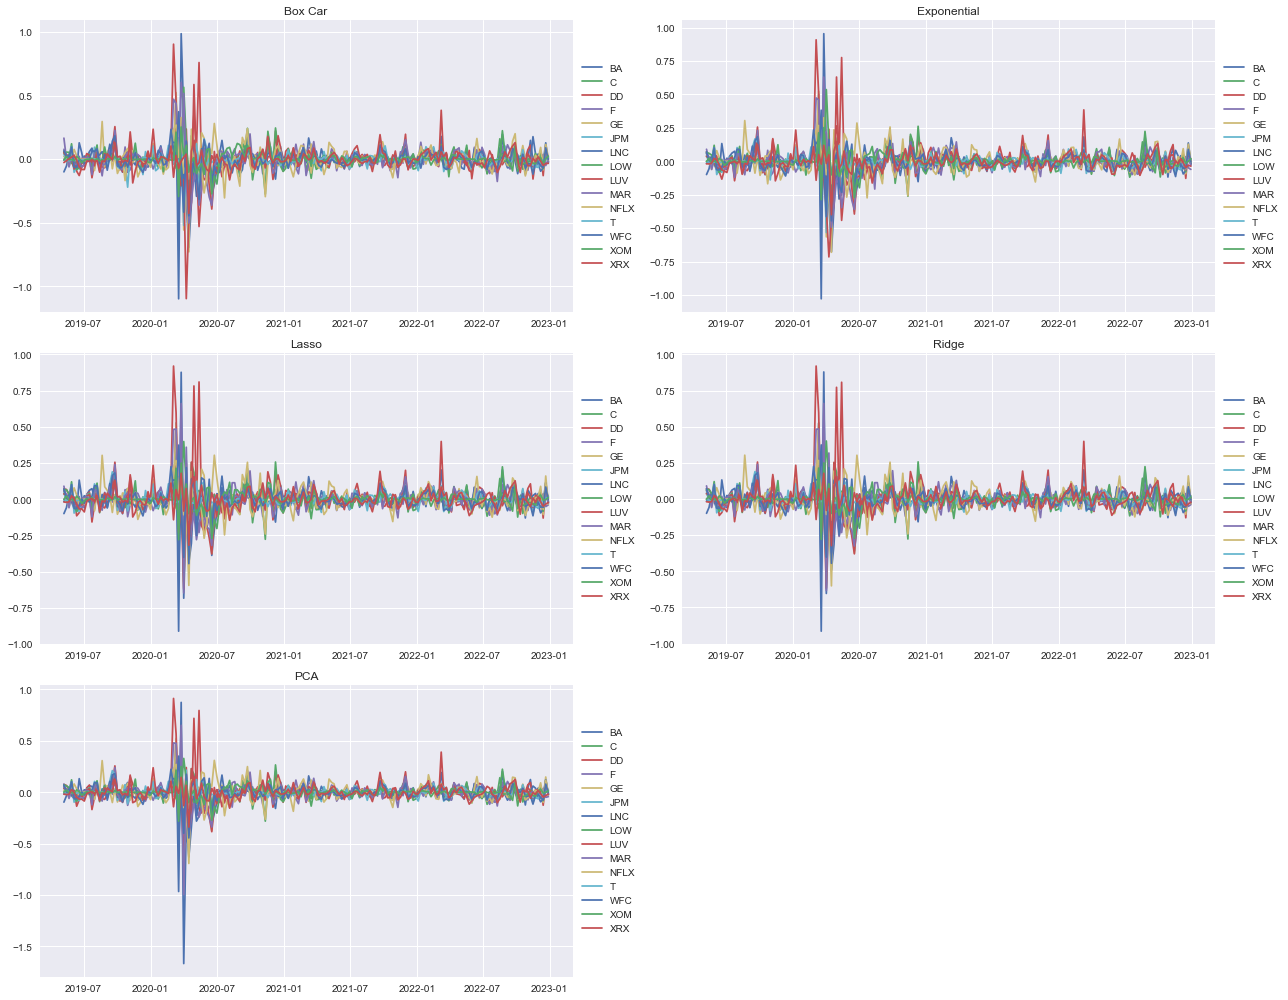

In [1333]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(18, 14))

axs[0, 0].plot(residual_errors_box_car_16, label = residual_errors_box_car_16.columns )
axs[0, 0].set_title("Box Car")
axs[0,0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[0, 1].plot(residual_errors_exponential_12, label = residual_errors_exponential_12.columns)
axs[0, 1].set_title("Exponential")
axs[0,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[1, 0].plot(residual_errors_lasso, label = residual_errors_lasso.columns)
axs[1, 0].set_title("Lasso")
axs[1,0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[1, 1].plot(residual_errors_ridge, label =residual_errors_ridge.columns )
axs[1, 1].set_title("Ridge")
axs[1,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[2, 0].plot(residual_errors_pca, label = residual_errors_pca.columns)
axs[2, 0].set_title("PCA")
axs[2,0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[2, 1].remove()

plt.tight_layout()
plt.show()


### Observations:
- We can infer that the residuals obtained through all the 4 regressions are also very close to each other with a very small difference in order of 0.001.<br><br>
- In general, if we look at the magnitude of residuals, we see that the general trend is PCA< exponential = lasso < Ridge < Boxcar.<br><br>
- But the magnitude of difference between all 4 are very small and we can infer all 4 models are doing same job in predicting the residuals.<br><br>

### Residual plot for Boxcar and Exponential with different half life and window size

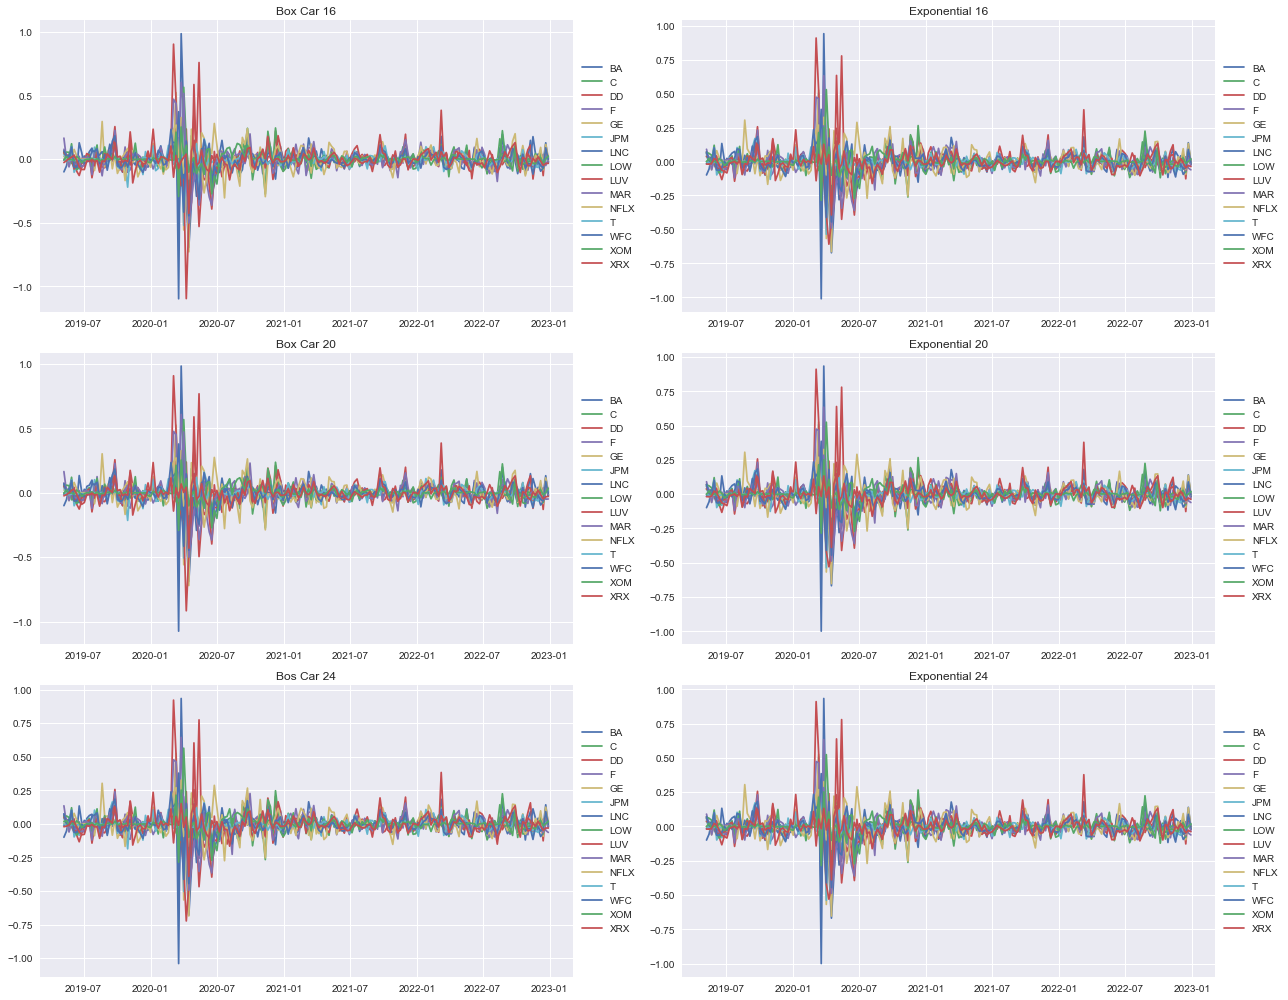

In [1334]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(18, 14))

axs[0, 0].plot(residual_errors_box_car_16, label = residual_errors_box_car_16.columns )
axs[0, 0].set_title("Box Car 16")
axs[0,0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[0, 1].plot(residual_errors_exponential_16, label = residual_errors_exponential_16.columns)
axs[0, 1].set_title("Exponential 16")
axs[0,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[1, 0].plot(residual_errors_box_car_20, label = residual_errors_box_car_20.columns)
axs[1, 0].set_title("Box Car 20")
axs[1,0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[1, 1].plot(residual_errors_exponential_20, label = residual_errors_exponential_20.columns)
axs[1, 1].set_title("Exponential 20")
axs[1,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[2, 0].plot(residual_errors_box_car_24, label =residual_errors_box_car_24.columns)
axs[2, 0].set_title("Bos Car 24")
axs[2,0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axs[2, 1].plot(residual_errors_exponential_24, label =residual_errors_exponential_24.columns)
axs[2, 1].set_title("Exponential 24")
axs[2,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.tight_layout()
plt.show()



### Observations:
- We can infer that the residuals obtained through different combnations of regressions are also very close to each other with a very small difference in order of 0.001.<br><br>
- When we increase the window size of a boxcar moving average, we increase the number of data points that are included in each moving average calculation. This means that the resulting smoothed series will have less variation and be smoother than the original series. However, a larger window size may also result in more lag in the resulting smoothed series, as it takes more data points to respond to changes in the original series.<br><br>
- On the other hand, when we increase the half-life of an exponential decay in an exponential smoothing model, we give more weight to the most recent observations in the time series. This means that the resulting smoothed series will respond more quickly to changes in the original series, but will also have more variability than a smoothed series with a smaller half-life.<br><br>
- A larger window size or a smaller half-life will result in more smoothing, but may also result in a loss of information or lag in the resulting smoothed series.<br><br>
- A smaller window size or a larger half-life will result in less smoothing and may allow more information to be retained, but may also result in a more volatile smoothed series.<br><br>

### Residual plot for Boxcar, Exponential, Lasso, Ridge and PCA for individual tickers

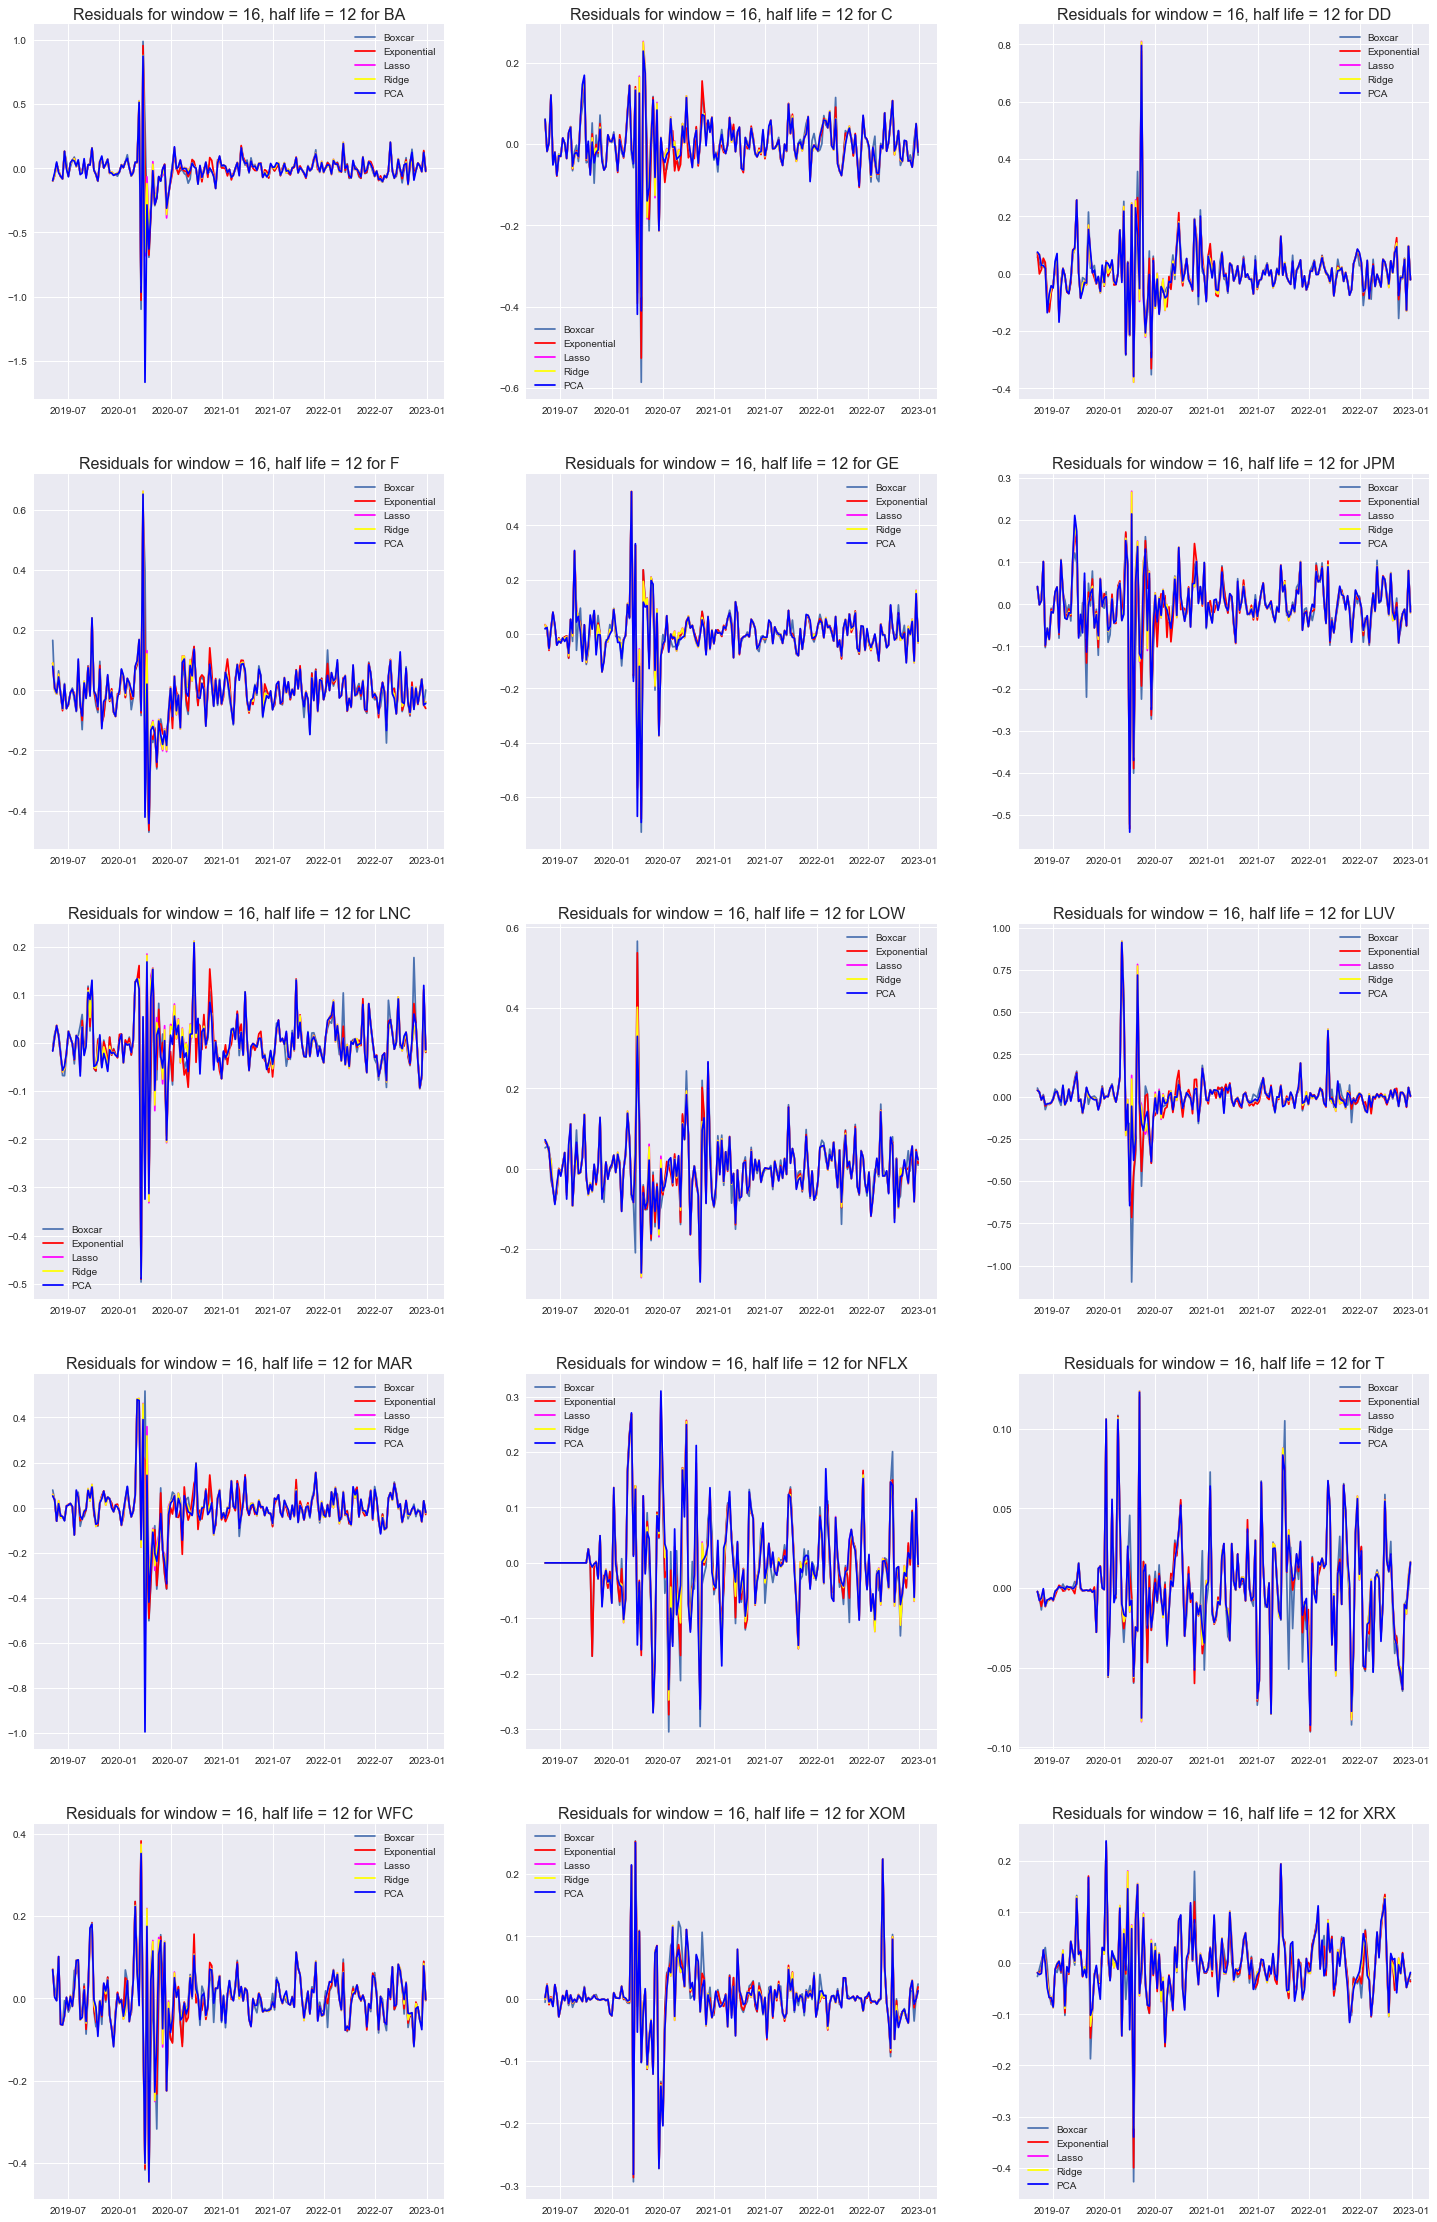

In [1335]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(25, 40))

axs = axs.ravel()

for i, col in enumerate(residual_errors_exponential.columns):
    ax = axs[i]  
    ax.plot(residual_errors_box_car_16.index, residual_errors_box_car_16[col], label='Boxcar')
    ax.plot(residual_errors_exponential_12.index, residual_errors_exponential_12[col], label = 'Exponential', c='red')
    ax.plot(residual_errors_lasso.index, residual_errors_lasso[col], label='Lasso', c='magenta')
    ax.plot(residual_errors_ridge.index, residual_errors_ridge[col], label='Ridge', c='yellow')
    ax.plot(residual_errors_pca.index, residual_errors_pca[col], label='PCA', c='blue')
    ax.set_title('Residuals for window = 16, half life = 12 for ' + col, fontsize=16)
    ax.legend()


### Observations:
- Ticker BA seems to have higher residual values on the negative side around -1.5.<br><br>
- Ticker T seems to have snmaller residuals values on both positive and negative sides.<br><br>

# Historical Trend Analysis

### Observations:
- We could see that time series has observed fluctuations mainly around March of 2020 and tend to have higher values. For rest of the period, it seems to be almost stable. <br><br>
- Economic Initution: CDS spreads are a measure of credit risk, and are often used to assess the likelihood of default or credit events for a particular entity, such as a company or a sovereign nation.The pandemic led to significant disruptions in economic activity, and many businesses and individuals faced financial difficulties as a result. This could have led to an increase in credit risk, as lenders became more cautious about extending credit to borrowers. Additionally, the pandemic may have increased the risk of credit events, such as defaults or bankruptcies, which could have contributed to the increase in CDS spreads.Additionally, changes in interest rates or other market conditions could also have contributed to changes in credit risk and CDS spreads during this period.<br><br>

### Performance Summary function

In [1338]:
def performance_summary(return_data):

    summary_stats = return_data.mean().to_frame('Mean')*12
    summary_stats['Median'] = return_data.median()
    summary_stats['Volatility'] = return_data.std()*np.sqrt(12)
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['1% quantile'] = return_data.quantile(.01, axis = 0)
    summary_stats['2% quantile'] = return_data.quantile(.02, axis = 0)
    summary_stats['10% quantile'] = return_data.quantile(.10, axis = 0)
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    cum_returns = (1 + return_data).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    summary_stats['max_drawdown'] = drawdown.min()
    
    return summary_stats.round(3)

### Performance Summary for  half life 12 and window size 16

### Exponential

In [1339]:
performance_summary(residual_errors_exponential_12).T

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
Mean,-0.143,-0.041,0.026,-0.077,0.007,-0.037,-0.035,-0.030,-0.109,-0.079,-0.015,-0.005,-0.034,0.018,-0.048
Median,-0.010,-0.007,-0.003,-0.009,-0.001,-0.005,-0.004,-0.005,-0.011,-0.008,-0.001,-0.001,-0.004,0.001,-0.009
Volatility,0.487,0.252,0.349,0.307,0.360,0.265,0.239,0.278,0.472,0.347,0.289,0.110,0.278,0.192,0.220
Sharpe Ratio,-0.293,-0.163,0.074,-0.249,0.021,-0.141,-0.148,-0.106,-0.231,-0.227,-0.054,-0.044,-0.122,0.094,-0.220
Skewness,-0.759,-2.343,2.198,1.158,-1.547,-2.407,-2.076,1.601,1.228,-0.120,0.304,0.478,-0.898,-0.518,-0.666
Excess Kurtosis,28.190,16.851,19.330,16.640,17.647,14.981,14.987,11.053,18.101,8.770,2.312,2.261,10.548,10.877,8.636
VaR (0.05),-0.117,-0.074,-0.122,-0.120,-0.097,-0.092,-0.070,-0.110,-0.126,-0.127,-0.118,-0.055,-0.087,-0.065,-0.094
CVaR (0.05),-0.366,-0.181,-0.204,-0.191,-0.251,-0.201,-0.172,-0.160,-0.337,-0.270,-0.186,-0.068,-0.204,-0.144,-0.144
1% quantile,-0.376,-0.227,-0.286,-0.195,-0.393,-0.276,-0.266,-0.181,-0.443,-0.348,-0.259,-0.079,-0.250,-0.205,-0.148
2% quantile,-0.311,-0.122,-0.186,-0.154,-0.161,-0.150,-0.114,-0.144,-0.360,-0.298,-0.167,-0.068,-0.186,-0.123,-0.112


### Boxcar

In [1340]:
performance_summary(residual_errors_box_car_16).T

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
Mean,-0.144,-0.039,0.038,-0.091,-0.000,-0.068,-0.030,-0.032,-0.107,-0.046,-0.039,-0.010,-0.056,0.035,-0.058
Median,-0.012,-0.003,-0.003,-0.008,-0.002,-0.004,-0.003,-0.004,-0.005,-0.002,-0.001,-0.001,-0.005,0.001,-0.008
Volatility,0.512,0.254,0.353,0.329,0.368,0.267,0.237,0.295,0.512,0.364,0.296,0.114,0.281,0.197,0.227
Sharpe Ratio,-0.281,-0.154,0.109,-0.278,-0.000,-0.253,-0.128,-0.110,-0.210,-0.126,-0.131,-0.091,-0.201,0.178,-0.257
Skewness,-0.864,-2.869,2.095,1.034,-1.739,-2.445,-1.991,1.547,-0.829,0.248,0.114,0.503,-1.109,-0.501,-0.909
Excess Kurtosis,28.042,21.769,17.497,12.820,18.472,13.710,15.430,10.671,25.109,9.863,2.454,2.082,10.567,10.191,9.875
VaR (0.05),-0.117,-0.080,-0.129,-0.131,-0.100,-0.095,-0.075,-0.112,-0.156,-0.125,-0.131,-0.054,-0.102,-0.062,-0.090
CVaR (0.05),-0.376,-0.187,-0.206,-0.209,-0.263,-0.217,-0.167,-0.175,-0.381,-0.272,-0.196,-0.069,-0.209,-0.145,-0.152
1% quantile,-0.381,-0.221,-0.290,-0.264,-0.392,-0.285,-0.213,-0.212,-0.481,-0.362,-0.269,-0.077,-0.327,-0.203,-0.166
2% quantile,-0.302,-0.125,-0.173,-0.174,-0.171,-0.221,-0.113,-0.166,-0.353,-0.305,-0.177,-0.070,-0.149,-0.123,-0.112


# Plotting Histograms and Calculating Skewness and Kurtosis for analyzing Tail Risk

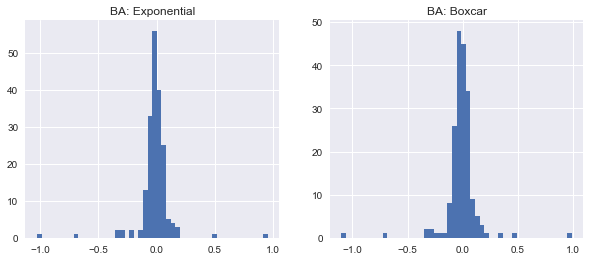

Skewness (BA):
Exponential: -0.752663793982133
Boxcar: -0.856805481391738

Kurtosis (BA):
Exponential: 27.42614083118639
Boxcar: 27.282450263801692


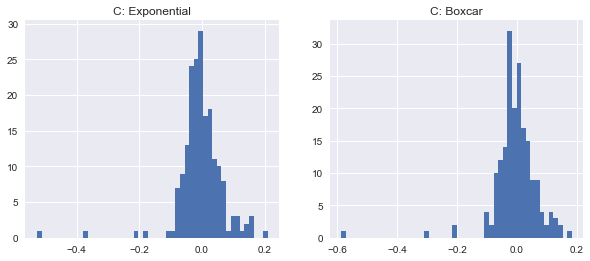

Skewness (C):
Exponential: -2.3249076065692194
Boxcar: -2.8463600296937575

Kurtosis (C):
Exponential: 16.381890971433307
Boxcar: 21.171602340258964


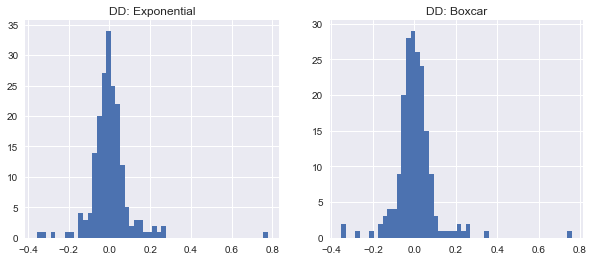

Skewness (DD):
Exponential: 2.1810602263992425
Boxcar: 2.078325290987562

Kurtosis (DD):
Exponential: 18.79614881497209
Boxcar: 17.011260909111595


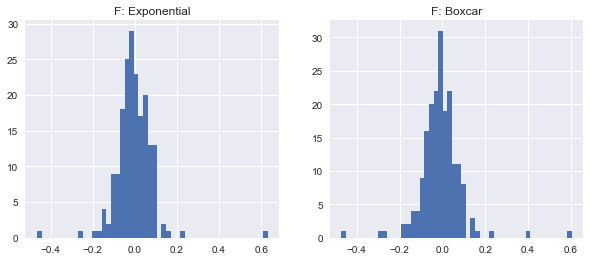

Skewness (F):
Exponential: 1.149331314221938
Boxcar: 1.0254605989769665

Kurtosis (F):
Exponential: 16.176619249532962
Boxcar: 12.455465668685797


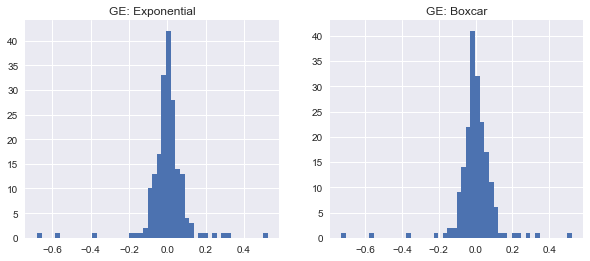

Skewness (GE):
Exponential: -1.5351919765714777
Boxcar: -1.7251116288701585

Kurtosis (GE):
Exponential: 17.157223779827014
Boxcar: 17.960645033227692


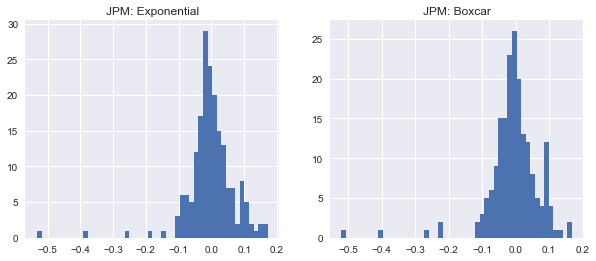

Skewness (JPM):
Exponential: -2.387902676067934
Boxcar: -2.4255762520226676

Kurtosis (JPM):
Exponential: 14.560696171408047
Boxcar: 13.322306569087011


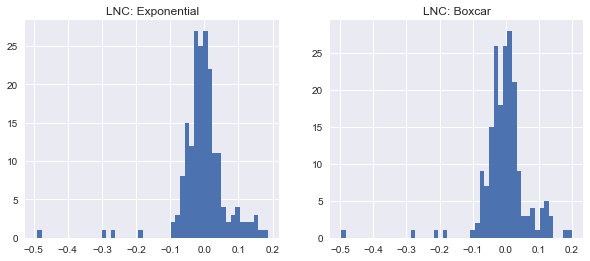

Skewness (LNC):
Exponential: -2.0594243501535225
Boxcar: -1.9757782820328338

Kurtosis (LNC):
Exponential: 14.566566106498247
Boxcar: 14.997856623403877


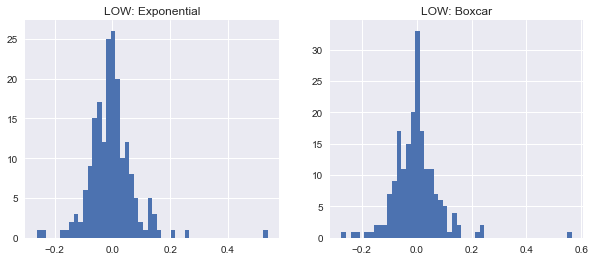

Skewness (LOW):
Exponential: 1.5883199100242822
Boxcar: 1.5344024812652268

Kurtosis (LOW):
Exponential: 10.734362934425604
Boxcar: 10.362758858325781


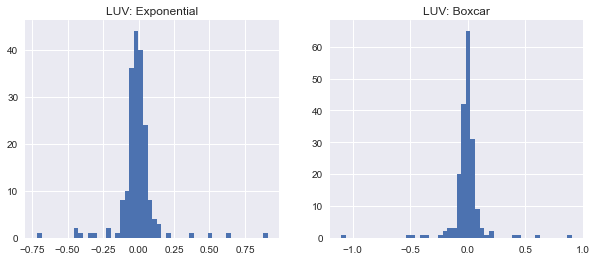

Skewness (LUV):
Exponential: 1.2185648661616886
Boxcar: -0.8225758713546681

Kurtosis (LUV):
Exponential: 17.59963157019127
Boxcar: 24.425588192115328


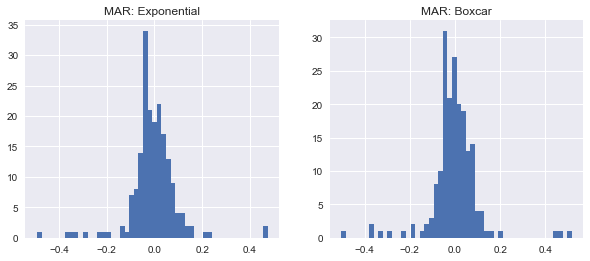

Skewness (MAR):
Exponential: -0.11856402886419301
Boxcar: 0.2458242566708281

Kurtosis (MAR):
Exponential: 8.51131965193913
Boxcar: 9.57509813893535


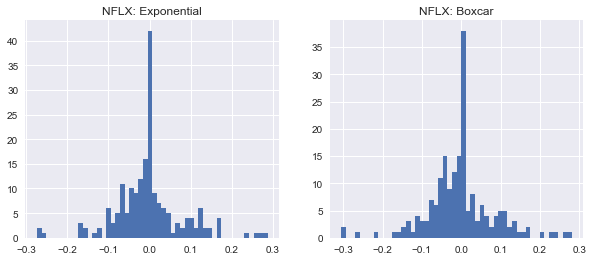

Skewness (NFLX):
Exponential: 0.30152829146383314
Boxcar: 0.11261531087204338

Kurtosis (NFLX):
Exponential: 2.220345316423077
Boxcar: 2.358944468706282


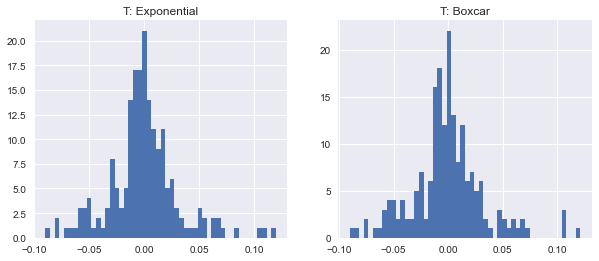

Skewness (T):
Exponential: 0.47387398468684555
Boxcar: 0.4988144035059021

Kurtosis (T):
Exponential: 2.1708779763727444
Boxcar: 1.9964217648622649


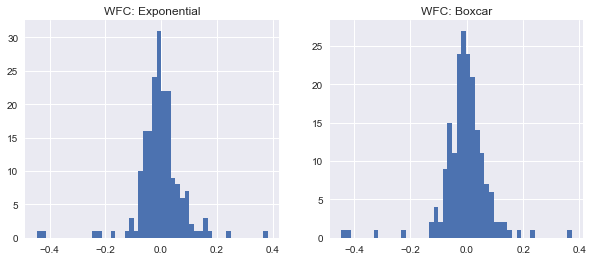

Skewness (WFC):
Exponential: -0.891293094210872
Boxcar: -1.099847665638681

Kurtosis (WFC):
Exponential: 10.243106529647799
Boxcar: 10.260879206074986


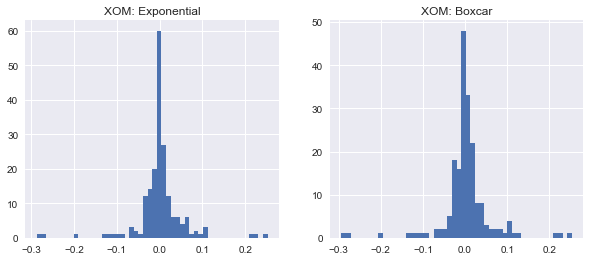

Skewness (XOM):
Exponential: -0.5135280709062896
Boxcar: -0.49727060932402045

Kurtosis (XOM):
Exponential: 10.56331455744724
Boxcar: 9.894850207985494


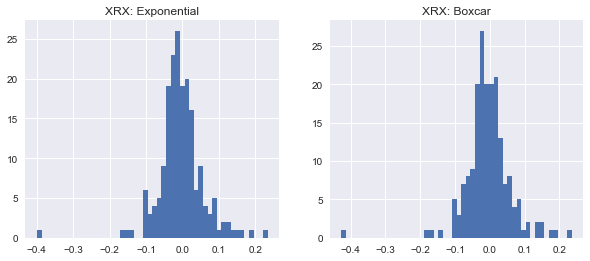

Skewness (XRX):
Exponential: -0.6608485639736272
Boxcar: -0.901624549539746

Kurtosis (XRX):
Exponential: 8.380016187257578
Boxcar: 9.587314221405283


In [1395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Assume you have a dataframe `residuals_exp` containing the residuals for the exponential method and a dataframe `residuals_boxcar` containing the residuals for the boxcar method for each ticker.

tickers = residual_errors_exponential_12.columns

# Loop over the tickers and plot the histograms of the residuals for each method.
for ticker in tickers:
    residuals_exp_ticker = residual_errors_exponential_12[ticker]
    residuals_boxcar_ticker = residual_errors_box_car_16[ticker]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].hist(residuals_exp_ticker, bins=50)
    axs[0].set_title(f'{ticker}: Exponential')
    axs[1].hist(residuals_boxcar_ticker, bins=50)
    axs[1].set_title(f'{ticker}: Boxcar')
    plt.show()

    # Calculate the skewness and kurtosis of the residuals for each method.
    skewness_exp = skew(residuals_exp_ticker)
    skewness_boxcar = skew(residuals_boxcar_ticker)
    kurtosis_exp = kurtosis(residuals_exp_ticker)
    kurtosis_boxcar = kurtosis(residuals_boxcar_ticker)

    print(f'Skewness ({ticker}):')
    print('Exponential:', skewness_exp)
    print('Boxcar:', skewness_boxcar)
    print(f'\nKurtosis ({ticker}):')
    print('Exponential:', kurtosis_exp)
    print('Boxcar:', kurtosis_boxcar)

### Observations:
- Mean of residuals seems to be almost same in both the cases, which means both models aree almost doing good job in  predicting.<br><br>
- Excess Kurtosis of both seems to be simnilar, on an average exponential seems to be slightly higher than the boxcar. <br><br>
- Exponential seems to have higher tails than compared to boxcar in general due to higher kurtosis. <br><br>
- In general, the kurtosis of the residuals is more likely to be higher in an exponential decay smoothing model than in a boxcar moving average. This is because the exponential decay smoothing model tends to give more weight to recent observations, which can result in a more responsive but potentially more volatile smoothed series. This can sometimes lead to more extreme values in the residuals, resulting in higher kurtosis. On the other hand, a boxcar moving average applies an equal weight to all observations within the window size, which can help to reduce the volatility of the smoothed series and the resulting residuals. This can sometimes lead to lower kurtosis in the residuals.<br><br>
- Skewness of both seems to be similar. In general, we can see histogram seems to have data points towards left skewed in both of the cases. <br><br>
- In general, a boxcar moving average tends to produce smoother, less volatile smoothed series than an exponential decay, and this can result in a lower skewness in the residual values. This is because the boxcar moving average applies an equal weight to all observations within the window size, which can help reduce any biases or trends in the data. On the other hand, an exponential decay gives more weight to recent observations, which can result in a more responsive but potentially more volatile smoothed series. This can sometimes lead to higher skewness in the residual values, particularly if there are any trends or patterns in the original time series that are not captured by the smoothing model.<br><br>



# Testing the Autocorrelation of Time Series

### ACF plots for Exponential

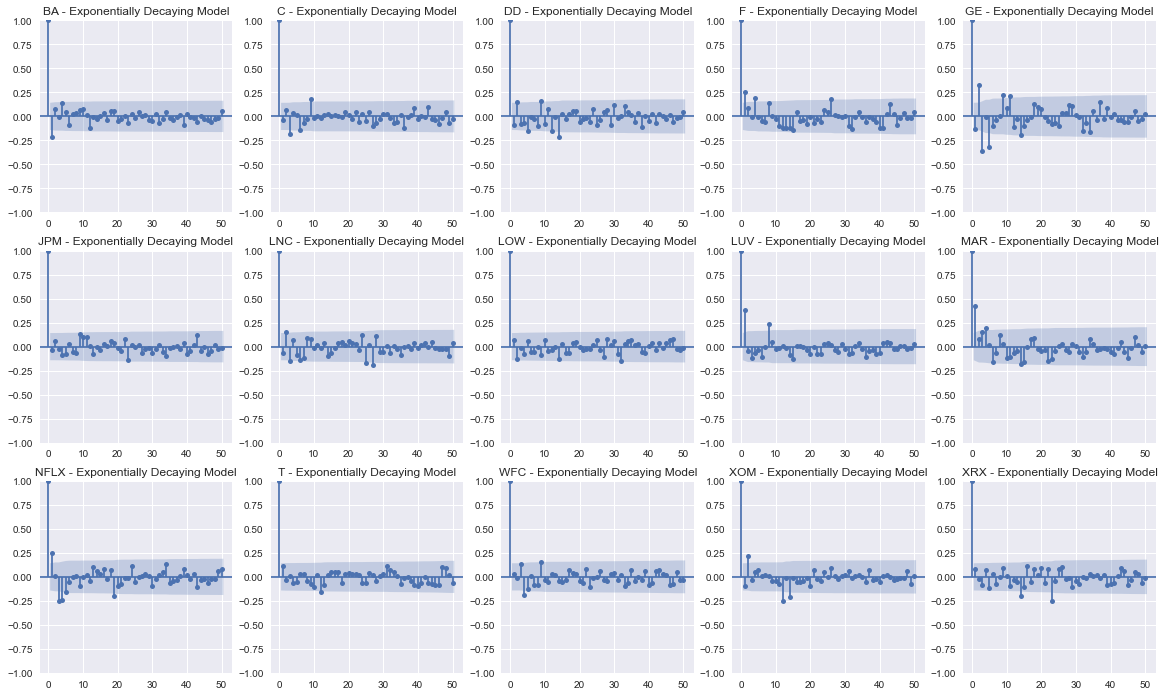

In [1371]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set the residuals for the exponentially decaying model and the boxcar model
residuals_exp = residual_errors_exponential_12

# Plot the ACF for the exponentially decaying model's errors
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, col in enumerate(residuals_exp.columns):
    ax = axs[i // 5, i % 5]
    sm.graphics.tsa.plot_acf(residuals_exp[col], lags=50, ax=ax)
    ax.set_title(f'{col} - Exponentially Decaying Model')
plt.show()


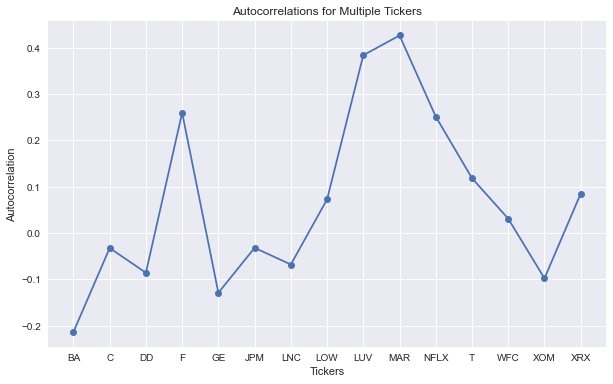

In [1344]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set the residuals for the exponentially decaying model and the boxcar model
residuals_boxcar = residual_errors_box_car_16

# Plot the ACF for the boxcar model's errors
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, col in enumerate(residuals_boxcar.columns):
    ax = axs[i // 5, i % 5]
    sm.graphics.tsa.plot_acf(residuals_boxcar[col], lags=50, ax=ax)
    ax.set_title(f'{col} - Boxcar Model')
plt.show()


import pandas as pd
import matplotlib.pyplot as plt


# Compute autocorrelations for each column
autocorr = residual_errors_exponential_12.apply(lambda x: x.autocorr())

# Plot autocorrelations for each column on the same graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(autocorr.index, autocorr.values, marker='o')
ax.set_xlabel('Tickers')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelations for Multiple Tickers')
plt.show()


### ACF plots for Boxcar

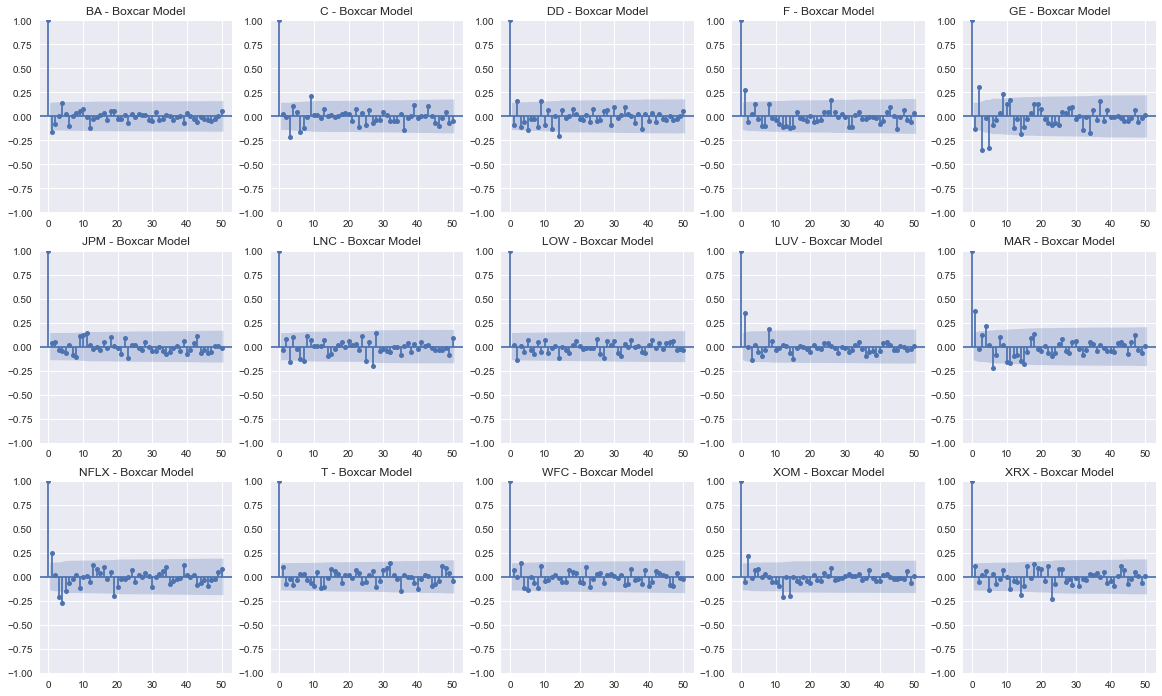

In [1375]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set the residuals for the exponentially decaying model and the boxcar model
residuals_boxcar = residual_errors_box_car_16

# Plot the ACF for the boxcar model's errors
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, col in enumerate(residuals_boxcar.columns):
    ax = axs[i // 5, i % 5]
    sm.graphics.tsa.plot_acf(residuals_boxcar[col], lags=50, ax=ax)
    ax.set_title(f'{col} - Boxcar Model')
plt.show()


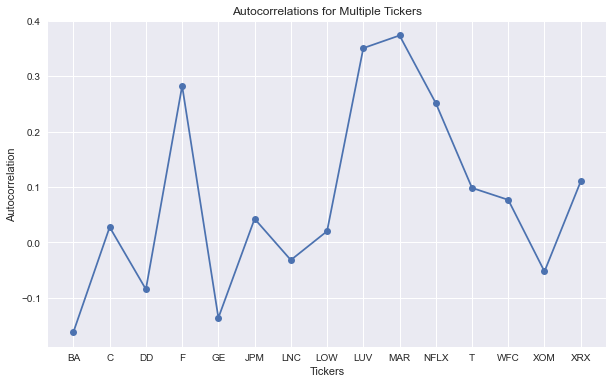

In [1343]:
import pandas as pd
import matplotlib.pyplot as plt


# Compute autocorrelations for each column
autocorr = residual_errors_box_car_16.apply(lambda x: x.autocorr())

# Plot autocorrelations for each column on the same graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(autocorr.index, autocorr.values, marke='o')
ax.set_xlabel('Tickers')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelations for Multiple Tickers')
plt.show()


### Observations:
- We can infer that for some of the tickers, we have small moderate positive autocorrelation ranging from 0 to 0.3 in both of the regressions. This suggests that there is a moderate positive correlation between the time series and its past lags at these specific lag values. However, the correlation is not particularly strong, as the values are relatively low. <br><br>
- We can infer that for some of the tickers, we have small moderate negative autocorrelation ranging from 0 to -0.1 in both of the regressions. A negative correlation means that when the value of the time series increases, the value of the lagged series tends to decrease, and vice versa. However, the correlation is not particularly strong, as the values are relatively low. <br><br>

- In general, the autocorrelation values of the residuals are more likely to be higher in an exponential decay smoothing model than in a boxcar moving average. This is because the exponential decay smoothing model tends to give more weight to recent observations, which can result in a more responsive but potentially more volatile smoothed series. This can sometimes lead to more extreme values in the residuals, resulting in higher autocorrelation values.On the other hand, a boxcar moving average applies an equal weight to all observations within the window size, which can help to reduce the volatility of the smoothed series and the resulting residuals. This can sometimes lead to lower autocorrelation in the residuals.<br><br>


# Testing the Stationarity of Time series of residuals

### Augmented Dickey-Fuller (ADF) test for Boxcar

In [1345]:
import statsmodels.api as sm
import pandas as pd

adf_results = []

for col in residual_errors_box_car_16.columns:
    adf_output = sm.tsa.stattools.adfuller(residual_errors_box_car_16[col].values)
    adf_statistic = adf_output[0]
    adf_pvalue = adf_output[1]
    adf_critical_values = adf_output[4]

    adf_results.append({
        'Column': col,
        'ADF Statistic': adf_statistic,
        'p-value': adf_pvalue,
        'Critical Value (1%)': adf_critical_values['1%'],
        'Critical Value (5%)': adf_critical_values['5%'],
        'Critical Value (10%)': adf_critical_values['10%']
    })

adf_df = pd.DataFrame(adf_results)
adf_df.set_index('Column', inplace=True)
adf_df.sort_values(by='ADF Statistic', inplace=True)
adf_df


,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Column,,,,,
BA,-16.154630,4.531698e-29,-3.465244,-2.876875,-2.574945
JPM,-13.150287,1.371421e-24,-3.465244,-2.876875,-2.574945
T,-12.413620,4.288806e-23,-3.465244,-2.876875,-2.574945
XRX,-12.272868,8.561710e-23,-3.465244,-2.876875,-2.574945
LOW,-10.998335,6.781418e-20,-3.465431,-2.876957,-2.574988
GE,-9.387321,6.704725e-16,-3.466201,-2.877293,-2.575168
XOM,-7.958848,2.986159e-12,-3.465431,-2.876957,-2.574988
DD,-7.468039,5.142060e-11,-3.466005,-2.877208,-2.575122
NFLX,-7.023352,6.457847e-10,-3.466800,-2.877555,-2.575308


### Augmented Dickey-Fuller (ADF) test for Exponential

In [1346]:
import statsmodels.api as sm
import pandas as pd

adf_results = []

for col in residual_errors_exponential_12.columns:
    adf_output = sm.tsa.stattools.adfuller(residual_errors_exponential_12[col].values)
    adf_statistic = adf_output[0]
    adf_pvalue = adf_output[1]
    adf_critical_values = adf_output[4]

    adf_results.append({
        'Column': col,
        'ADF Statistic': adf_statistic,
        'p-value': adf_pvalue,
        'Critical Value (1%)': adf_critical_values['1%'],
        'Critical Value (5%)': adf_critical_values['5%'],
        'Critical Value (10%)': adf_critical_values['10%']
    })

adf_df = pd.DataFrame(adf_results)
adf_df.set_index('Column', inplace=True)
adf_df.sort_values(by='ADF Statistic', inplace=True)
adf_df


,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Column,,,,,
BA,-17.046149,8.131160e-30,-3.465244,-2.876875,-2.574945
JPM,-14.169309,2.016308e-26,-3.465244,-2.876875,-2.574945
XRX,-12.583589,1.887042e-23,-3.465244,-2.876875,-2.574945
T,-12.166641,1.452199e-22,-3.465244,-2.876875,-2.574945
LOW,-10.645262,4.813971e-19,-3.465431,-2.876957,-2.574988
GE,-9.273504,1.307559e-15,-3.466201,-2.877293,-2.575168
NFLX,-8.851842,1.565289e-14,-3.465812,-2.877123,-2.575077
XOM,-8.143133,1.015474e-12,-3.465431,-2.876957,-2.574988
DD,-7.563674,2.964240e-11,-3.466005,-2.877208,-2.575122


### Observations:
- Null hypothesis: The null hypothesis of the ADF test is that the time series has a unit root and is non-stationary. The alternative hypothesis is that the time series is stationary. <br><br>
- Here we can see that the absolute value of the test statistic is greater than the critical values, thus we reject the null hypothesis in favor of the alternative hypothesis of stationarity.<br><br>

- Here we can see that the p-value is less than 0.05, thus we reject the null hypothesis of a unit root in favor of the alternative hypothesis of stationarity.<br><br>

- Thus in both the cases of regression, we can infer that from both t stat and p value, we reject null hypothesis and conclude time series is very stationary. <br><br>


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for Boxcar

In [1347]:
import pandas as pd
import statsmodels.api as sm
residuals = residual_errors_box_car_16
kpss_results = []
for col in residuals.columns:
    res = residuals[col]
    kpss_stat, kpss_pval, kpss_lags, kpss_critval = sm.tsa.stattools.kpss(res)
    kpss_results.append([kpss_stat, kpss_pval, kpss_critval['1%'], kpss_critval['5%'], kpss_critval['10%']])

kpss_df = pd.DataFrame(kpss_results, index=residuals.columns, columns=['KPSS Statistic', 'p-value', '1% Crit. Val.', '5% Crit. Val.', '10% Crit. Val.'])
kpss_df

,KPSS Statistic,p-value,1% Crit. Val.,5% Crit. Val.,10% Crit. Val.
BA,0.127566,0.1,0.739,0.463,0.347
C,0.169419,0.1,0.739,0.463,0.347
DD,0.037033,0.1,0.739,0.463,0.347
F,0.053326,0.1,0.739,0.463,0.347
GE,0.085502,0.1,0.739,0.463,0.347
JPM,0.172113,0.1,0.739,0.463,0.347
LNC,0.117190,0.1,0.739,0.463,0.347
LOW,0.043578,0.1,0.739,0.463,0.347
LUV,0.093407,0.1,0.739,0.463,0.347
MAR,0.042723,0.1,0.739,0.463,0.347


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for Exponential

In [1348]:
import pandas as pd
import statsmodels.api as sm
residuals = residual_errors_exponential_12
kpss_results = []
for col in residuals.columns:
    res = residuals[col]
    kpss_stat, kpss_pval, kpss_lags, kpss_critval = sm.tsa.stattools.kpss(res)
    kpss_results.append([kpss_stat, kpss_pval, kpss_critval['1%'], kpss_critval['5%'], kpss_critval['10%']])

kpss_df = pd.DataFrame(kpss_results, index=residuals.columns, columns=['KPSS Statistic', 'p-value', '1% Crit. Val.', '5% Crit. Val.', '10% Crit. Val.'])
kpss_df

,KPSS Statistic,p-value,1% Crit. Val.,5% Crit. Val.,10% Crit. Val.
BA,0.184132,0.1,0.739,0.463,0.347
C,0.091223,0.1,0.739,0.463,0.347
DD,0.021751,0.1,0.739,0.463,0.347
F,0.070614,0.1,0.739,0.463,0.347
GE,0.052782,0.1,0.739,0.463,0.347
JPM,0.091004,0.1,0.739,0.463,0.347
LNC,0.097271,0.1,0.739,0.463,0.347
LOW,0.027473,0.1,0.739,0.463,0.347
LUV,0.072247,0.1,0.739,0.463,0.347
MAR,0.065192,0.1,0.739,0.463,0.347


### Observations:
- Null hypothesis: The null hypothesis of the KPSS test is that the time series is stationary. The alternative hypothesis is that the time series has a unit root and is non-stationary. <br><br>
- Here we can see that the absolute value of the test statistic is less than the critical values, thus we fail to reject the null hypothesis.<br><br>

- Here we can see that the p-value is greater than 0.05, thus we fail to reject the null hypothesis.<br><br>

- Thus in both the cases of regression, we can infer that from both t stat and p value, we fail to reject null hypothesis and conclude time series is very stationary. <br><br>

- Thus both the ADF and KPSS test conclude that time series is stationary.<br><br>



# Testing the Normality of time series of residuals

### KS test for Boxcar

In [1361]:
import pandas as pd
import statsmodels.api as sm

residuals = residual_errors_box_car_16

# Create an empty list to store the KS test results
ks_results = []

for col in residuals.columns:
    res = residuals[col]
    ks_stat, ks_pval = sm.stats.diagnostic.kstest_normal(res)
    ks_results.append([ks_stat, ks_pval])

# Create a DataFrame to store the KS test results
ks_df = pd.DataFrame(ks_results, index=residuals.columns, columns=['KS Statistic', 'p-value'])

# Print the results
ks_df


,KS Statistic,p-value
BA,0.211102,0.001
C,0.125604,0.001
DD,0.150756,0.001
F,0.097883,0.001
GE,0.154943,0.001
JPM,0.125913,0.001
LNC,0.129516,0.001
LOW,0.105795,0.001
LUV,0.231840,0.001
MAR,0.149278,0.001


### KS test for Exponential

In [1362]:
import pandas as pd
import statsmodels.api as sm

residuals = residual_errors_exponential_12

# Create an empty list to store the KS test results
ks_results = []

for col in residuals.columns:
    res = residuals[col]
    ks_stat, ks_pval = sm.stats.diagnostic.kstest_normal(res)
    ks_results.append([ks_stat, ks_pval])

# Create a DataFrame to store the KS test results
ks_df = pd.DataFrame(ks_results, index=residuals.columns, columns=['KS Statistic', 'p-value'])

# Print the results
ks_df


,KS Statistic,p-value
BA,0.207938,0.001000
C,0.133914,0.001000
DD,0.149796,0.001000
F,0.086703,0.002009
GE,0.151338,0.001000
JPM,0.128880,0.001000
LNC,0.130287,0.001000
LOW,0.105100,0.001000
LUV,0.206760,0.001000
MAR,0.142842,0.001000


### Observations:
- Null hypothesis: The null hypothesis of the KS test for normality is that the sample is drawn from a normally distributed population. The alternative hypothesis is that the sample is not drawn from a normally distributed population. <br><br>
- Here we can see that for both the regressions the p-value is less than the 0.05, thus we reject the null hypothesis of normality and conclude that the sample is not drawn from a normally distributed population.<br><br>





### AD test for Boxcar

In [1398]:
import pandas as pd
import scipy.stats as stats

residuals = residual_errors_box_car_16

# Create an empty list to store the AD test results
ad_results = []

for col in residuals.columns:
    res = residuals[col]
    ad_stat, ad_crit, ad_sig = stats.anderson(res, 'norm')
    ad_results.append([ad_stat, ad_sig[2]])

# Create a DataFrame to store the AD test results
ad_df = pd.DataFrame(ad_results, index=residuals.columns, columns=['AD Statistic', 'Critical Value'])

# Print the results
ad_df


,AD Statistic,Critical Value
BA,17.042910,5.0
C,5.717073,5.0
DD,8.197169,5.0
F,4.663168,5.0
GE,10.899596,5.0
JPM,5.730635,5.0
LNC,6.639942,5.0
LOW,3.554440,5.0
LUV,20.846483,5.0
MAR,8.924751,5.0


### AD test for Exponential

In [1400]:
import pandas as pd
import scipy.stats as stats

residuals = residual_errors_exponential_12

# Create an empty list to store the AD test results
ad_results = []

for col in residuals.columns:
    res = residuals[col]
    ad_stat, ad_crit, ad_sig = stats.anderson(res, 'norm')
    ad_results.append([ad_stat, ad_sig[2]])

# Create a DataFrame to store the AD test results
ad_df = pd.DataFrame(ad_results, index=residuals.columns, columns=['AD Statistic', 'Critical Value'])

# Print the results
ad_df


,AD Statistic,Critical Value
BA,17.215501,5.0
C,6.233581,5.0
DD,7.774760,5.0
F,3.622722,5.0
GE,11.326186,5.0
JPM,5.509820,5.0
LNC,7.316882,5.0
LOW,3.606222,5.0
LUV,17.605800,5.0
MAR,7.364061,5.0


### Observations:
- Null hypothesis:  The null hypothesis of the AD test for normality is that the sample is drawn from a normally distributed population. The alternative hypothesis is that the sample is not drawn from a normally distributed population.<br><br>
- Here we can see that for both the regressions,  the AD statistic is greater than the critical value, thus we can reject the null hypothesis and conclude that the sample does not come from a normal distribution at that significance level.<br><br>





# Q-Q plots for Boxcar 

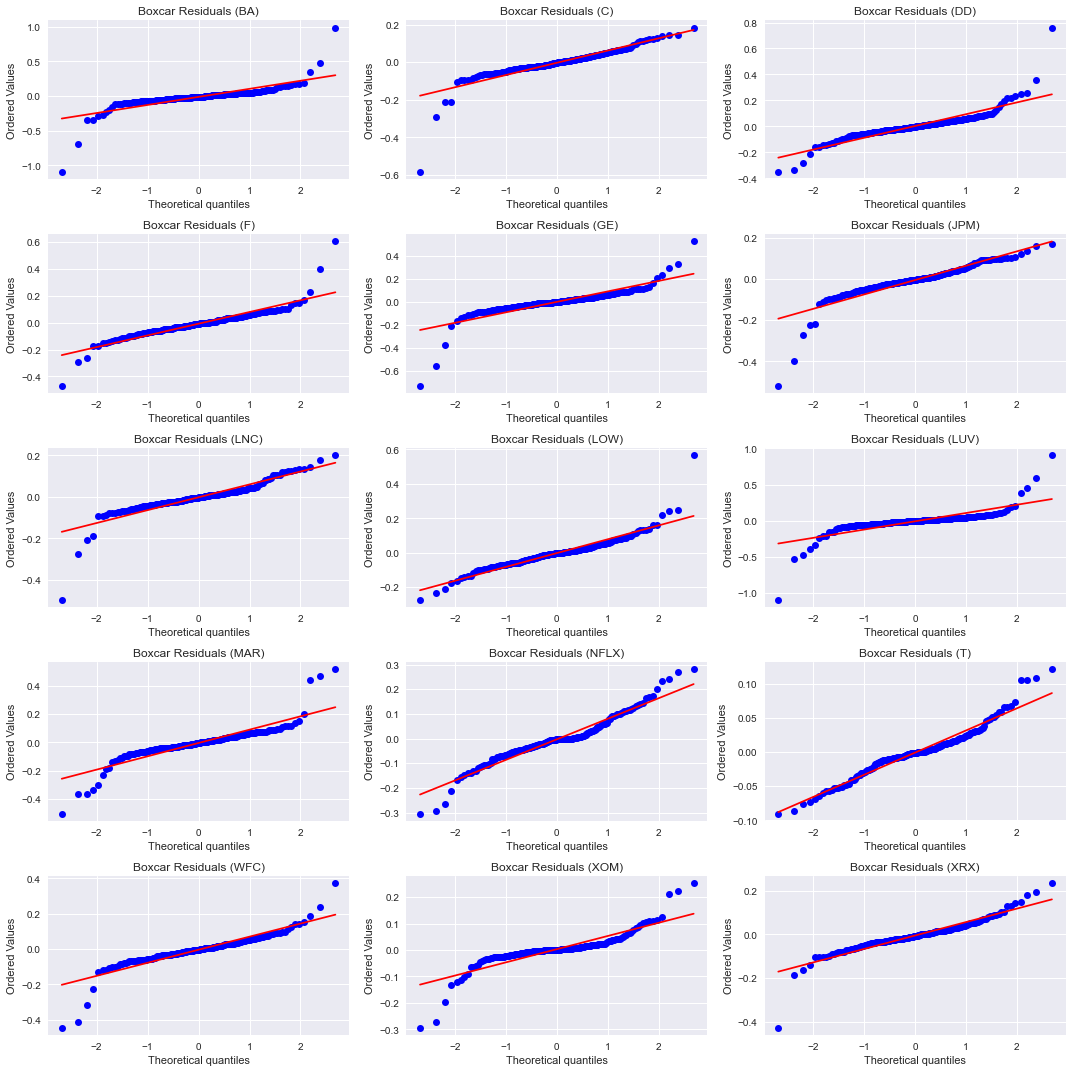

In [1379]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# assuming the boxcar and exponential residuals are stored in "boxcar_resid" and "exp_resid" DataFrames

# create a list of tickers
tickers = residual_errors_box_car_16.columns.tolist()

# calculate the number of rows and columns needed for the plot grid
n_rows = 5
n_cols = 3
n_plots = len(tickers)
n_grids = -(-n_plots // (n_rows * n_cols))  # equivalent to ceil(n_plots / (n_rows * n_cols))

# loop over each grid
for i in range(n_grids):
    # create a new figure and axis for the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    
    # loop over each subplot in the grid
    for j, ax in enumerate(axes.ravel()):
        # get the ticker for the subplot
        k = i * n_rows * n_cols + j
        if k < n_plots:
            ticker = tickers[k]
            
            # plot the Q-Q plot for the residuals of each model
            stats.probplot(residual_errors_box_car_16[ticker], dist="norm", plot=ax)
            ax.set_title("Boxcar Residuals ({})".format(ticker))

    # remove any unused subplots from the grid
    for j in range(n_plots, n_rows * n_cols):
        fig.delaxes(axes.ravel()[j])
    
    # adjust the layout and display the grid
    fig.tight_layout()
    plt.show()


# Q-Q plots for Exponential

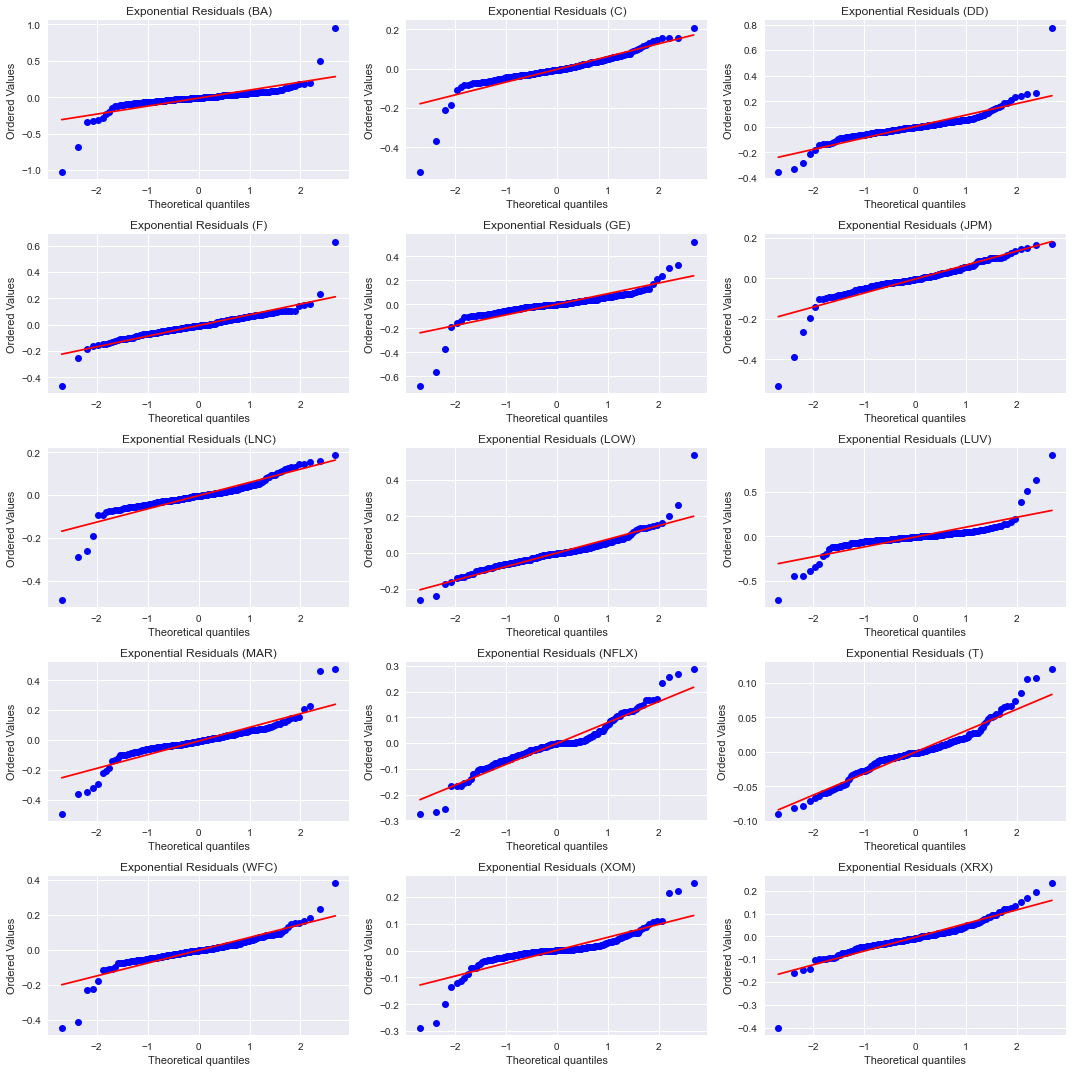

In [1380]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# assuming the boxcar and exponential residuals are stored in "boxcar_resid" and "exp_resid" DataFrames

# create a list of tickers
tickers = residual_errors_exponential_12.columns.tolist()

# calculate the number of rows and columns needed for the plot grid
n_rows = 5
n_cols = 3
n_plots = len(tickers)
n_grids = -(-n_plots // (n_rows * n_cols))  # equivalent to ceil(n_plots / (n_rows * n_cols))

# loop over each grid
for i in range(n_grids):
    # create a new figure and axis for the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    
    # loop over each subplot in the grid
    for j, ax in enumerate(axes.ravel()):
        # get the ticker for the subplot
        k = i * n_rows * n_cols + j
        if k < n_plots:
            ticker = tickers[k]
            
            # plot the Q-Q plot for the residuals of each model
            stats.probplot(residual_errors_exponential_12[ticker], dist="norm", plot=ax)
            ax.set_title("Exponential Residuals ({})".format(ticker))
            
    # remove any unused subplots from the grid
    for j in range(n_plots, n_rows * n_cols):
        fig.delaxes(axes.ravel()[j])
    
    # adjust the layout and display the grid
    fig.tight_layout()
    plt.show()


### Observations:
- The basic idea is to compare the quantiles of the observed data with those of the theoretical distribution, typically the normal distribution.<br><br>
- If the data is normally distributed, the points on the Q-Q plot will follow a straight line.<br><br>
- Here we see that in case of both regressions, the points on the Q-Q plot deviate from a straight line, it indicates that the data is not normally distributed <br><br>
- Thus all 3 tests KS, AD and Q-Q plot test gives us that it is not normally distributed. <br><br>





# My general comments and Economic Intuition of CDS Spreads

- CDS (Credit Default Swap) spreads are a measure of credit risk in financial markets. They represent the cost of protecting against the risk of a credit event, such as a default or bankruptcy, for a particular entity, such as a company or a sovereign nation.<br><br>
- The economic intuition behind CDS spreads is that they reflect the market's perception of the creditworthiness of the underlying entity. In other words, if the market believes that an entity is at high risk of default, then the CDS spread for that entity will be high, indicating that it is more expensive to insure against the risk of default.<br><br>
- CDS spreads are typically used as a benchmark for the cost of credit risk. Higher CDS spreads generally indicate higher credit risk and a greater likelihood of default. Conversely, lower CDS spreads indicate lower credit risk and a lower likelihood of default.<br><br>
- CDS spreads are also used as a tool for hedging against credit risk. For example, an investor who is exposed to the credit risk of a particular entity may purchase a CDS as a form of insurance against the risk of default. The cost of the CDS (i.e., the CDS spread) represents the premium that the investor pays to protect against the risk of default.<br><br>
- Overall, CDS spreads are an important measure of credit risk in financial markets, and they are used by investors, lenders, and other market participants to assess the creditworthiness of particular entities and to manage their exposure to credit risk.<br><br>

# Conclusion

- In general, residuals obtained from Boxcar and Exponential regression methods are small in magnitude, which suggests both models are good fit for the data and that there is little systematic error in our predictions.<br><br>
- In both regressions, we have observed that the autocorrelation values are modertaly positive and negative values and not much significant in magnitude. They exhibit less autocorrelation.<br><br>
- In both regressions, we have observed that through different tests, the time series of residuals are stationary.<br><br>
- In both regressions, we have observed that through different tests, the time series of residuals are not normally distributed.<br><br>
- To summarize, Boxcar regression is a non-parametric method that uses simple averaging to smooth out fluctuations in the data. It is a useful method when the underlying relationship between the dependent and independent variables is complex and difficult to model with a parametric equation. Boxcar regression is easy to implement and interpret, but may not capture all of the nuances of the relationship between the variables. <br><br>
- Exponential regression is a parametric method that assumes a specific functional form for the relationship between the dependent and independent variables. It is often used when the underlying relationship is expected to be exponential or logarithmic in nature. Exponential regression is more complex to implement and interpret than boxcar regression, but may provide a better fit to the data if the underlying relationship is well-described by an exponential function.<br><br>